In [1]:
import pandas as pd
import glob
import collections
import random
import numpy as np
from multiprocessing import Pool    
import functools
from collections import defaultdict
import os
import sys
import multiprocessing
import time
from functools import partial
import argparse
from tqdm import tqdm
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import ast 
from scipy.stats import wilcoxon
from scipy.stats import ranksums

# Helper Functions

In [2]:
def abs_path(target_name, directory_level): 
    """
Returns absolute file path of target name in working directory.

Arguments:
    target_name (str): Name of file or folder to find.
    directory_level (str): Level of os search, either File or Folder.   
    """
    #Find the relative working directory of the script
    wk_dir = os.path.dirname(os.path.realpath('__file__'))
    
    if directory_level == "File":
        #Absolute file path
        for root, dirs, files in os.walk(wk_dir):
            for name in files:
                if target_name == name:
                    target_path = (os.path.abspath(os.path.join(root, name))) 
             
    #Absolute file path
    if directory_level == "Directory":
        for root, dirs, files in os.walk(wk_dir):
            for name in dirs:
                if target_name == name:
                    target_path = (os.path.abspath(os.path.join(root, name))) 
    
    return target_path



def count_kmers(data, k):
    """
Count kmers in a sequence. Outputs dictionary.

Arguments:
    data (str): Input sequence.
    k (int): Length of k-mer.
    """
    global d
    d = collections.defaultdict(int)
    for i in range(len(data)-(k-1)):
        d[data[i:i+k]] +=1
    for key in list(d.keys()):
        if "N" in key:
            del d[key]
    return d
 
    

def read_fasta(fp):
    """
Reads fasta file. Outputs sequence.

Arguments:
    fp (str): Input fasta file. 
    """  
    name, seq = None, []
    for line in fp:
        line = line.rstrip()
        if line.startswith(">"):
            if name: yield (name, ''.join(seq))
            name, seq = line, []
        else:
            seq.append(line)
    if name: yield (name, ''.join(seq))





def seq_slice(sequence_abs_path, slice_start="all", slice_end="all"):
    """
Set slice of genome sequence (inclusive of start and end of slice) as a string (high memory cost...)

Arguments:
    sequence_abs_path (str): Absolute path of sequence
    slice_start (int): Start of string slice
    slice_end (int): End of string slice, inclusive
    """
    
    if slice_start == "all" and slice_end == "all":
        
        with open(sequence_abs_path) as fp:
            for name, seq in read_fasta(fp):
                sequence = str(seq)
                sample = sequence[:]
        
        return sample
    
    else:
        
        with open(sequence_abs_path) as fp:
            for name, seq in read_fasta(fp):
                sequence = str(seq)
                sample = sequence[int(slice_start):int(slice_end)]
        
        return sample

"""
Codon dictionary
"""
codon_dict = { 
       "CYS": ["TGT", "TGC"], 
       "ASP": ["GAT", "GAC"], 
       "SER": ["TCT", "TCG", "TCA", "TCC", "AGC", "AGT"], 
       "GLN": ["CAA", "CAG"], 
       "MET": ["ATG"], 
       "ASN": ["AAC", "AAT"], 
       "PRO": ["CCT", "CCG", "CCA", "CCC"], 
       "LYS": ["AAG", "AAA"], 
       "STOP": ["TAG", "TGA", "TAA"], 
       "THR": ["ACC", "ACA", "ACG", "ACT"], 
       "PHE": ["TTT", "TTC"], 
       "ALA": ["GCA", "GCC", "GCG", "GCT"], 
       "GLY": ["GGT", "GGG", "GGA", "GGC"], 
       "ILE": ["ATC", "ATA", "ATT"], 
       "LEU": ["TTA", "TTG", "CTC", "CTT", "CTG", "CTA"], 
       "HIS": ["CAT", "CAC"], 
       "ARG": ["CGA", "CGC", "CGG", "CGT", "AGG", "AGA"], 
       "TRP": ["TGG"], 
       "VAL": ["GTA", "GTC", "GTG", "GTT"], 
       "GLU": ["GAG", "GAA"], 
       "TYR": ["TAT", "TAC"]} 

"List of Cancer Types in PCAWG Dataset"
cancer_type_list = ['Biliary-AdenoCA',
 'Bladder-TCC',
 'Bone-Benign',
 'Bone-Epith',
 'Bone-Osteosarc',
 'Breast-AdenoCA',
 'Breast-DCIS',
 'Breast-LobularCA',
 'CNS-GBM',
 'CNS-Medullo',
 'CNS-Oligo',
 'CNS-PiloAstro',
 'Cervix-AdenoCA',
 'Cervix-SCC',
 'ColoRect-AdenoCA',
 'Eso-AdenoCA',
 'Head-SCC',
 'Kidney-ChRCC',
 'Kidney-RCC',
 'Liver-HCC',
 'Lung-AdenoCA',
 'Lung-SCC',
 'Lymph-BNHL',
 'Lymph-CLL',
 'Myeloid-AML',
 'Myeloid-MDS',
 'Myeloid-MPN',
 'Ovary-AdenoCA',
 'Panc-AdenoCA',
 'Panc-Endocrine',
 'Prost-AdenoCA',
 'Skin-Melanoma',
 'SoftTissue-Leiomyo',
 'SoftTissue-Liposarc',
 'Stomach-AdenoCA',
 'Thy-AdenoCA',
 'Uterus-AdenoCA']


def syn_codon_dict(codon_dict):
    """
Synonymous codon dictionary

Arguments:
    codon_dict (dict)
    """
    syn_codon_dict = {}
    for codon_set in list(codon_dict.values()):
        for codon in codon_set:
            syn_codon = codon_set[:]  
            syn_codon.remove(codon)
            syn_codon_dict.setdefault(codon, syn_codon)
    return syn_codon_dict
    


def ref_data(input_name, num=False, prop=False):
    """
Reads in reference datasets from PCAWG studies.

Arguments:
    input_name (str): Name of csv file 
    num (bool): Set true to return dataframe of PCAWG SigProfiler Signatures in Samples 
    prop (bool): Set true to return dataframe of SigProfiler Signature Contributions
    
Note: Must set only one of num or prop arguments to True. 
    """
    if prop == num:
        raise ValueError("Please set only one argument between the arguments num and prop to True.")
        
    if num is True:
        
        num_file_path = abs_path(input_name, "File")
        num_data = pd.read_csv(num_file_path)
        num_data.sort_values(by='Cancer Types', axis=0, inplace=True)
        num_data.set_index(keys=['Cancer Types'], drop=False,inplace=True)
        
        return num_data

    if prop is True:
            
        prop_file_path = abs_path(input_name, "File")
        prop_data = pd.read_csv(prop_file_path)
        
        return prop_data
    


def kmer_ref_count(kmer_length_start, kmer_length_end, ref_seq_name = "GRCh38.p13.genome.fasta", output_directory = "kmer_ref_count"):
    """
Count number of kmers of specified length in a fasta sequence. 
Used to count number of kmers in GChr.38

Arguments:
    kmer_length_start (int): Start counting kmers at this index
    kmer_length_end (int): Stop counting kmers at this index
    ref_seq_name (str): Name of file to count kmers from, default is the reference genome "GRCh38.p13.genome.fasta"
    output_directory (str): Name of folder to output kmer counts, default is the folder "kmer_ref_count"
    """
    input_file_path = abs_path(ref_seq_name, "File")
    
    with open(input_file_path) as fp:
        for name, seq in read_fasta(fp):
            for kmer_length in list(range(kmer_length_start, kmer_length_end+1)):
         
                count_kmers((str(seq)), kmer_length)
                count_df = pd.DataFrame.from_dict(d.keys())
                count_df['count'] = d.values()
                count_df.columns = [str(kmer_length), 'count']
        
                count_file_path = abs_path(output_directory, "Directory") + "/" + str(kmer_length)+'-mer_' + name + '.csv'
            
                with open(count_file_path, 'w'):
                    count_df.to_csv(count_file_path)
                    

#Cell 1 Loaded
print("Cell 1 of 5 Loaded")

#%%

"""
Input sequence file path
"""
#input_file_path = abs_path("Homo_sapiens.GRCh38.dna.chromosome.22.fasta", "File")

sig_weights =  pd.read_csv(abs_path("timelines_sigWeights.txt", "File"), sep='\t')
"""
Read in input reference files:
data = Pandas Dataframe of number of mutations attributed to each signature for each sample.
cancer_type = List of unique cancer types.
prop_data = Pandas Dataframe of proportion of 96 type mutation classification for each signature.
"""

"""
SBS input reference files
"""
sbs_num_file_path = abs_path("PCAWG_sigProfiler_SBS_signatures_in_samples.csv","File")
sbs_num_data = pd.read_csv(sbs_num_file_path)
sbs_num_data.sort_values(by='Cancer Types', axis=0, inplace=True)
sbs_num_data.set_index(keys=['Cancer Types'], drop=False,inplace=True)

sbs_prop_file_path = abs_path("sigProfiler_SBS_signatures.csv","File")
sbs_prop_data = pd.read_csv(sbs_prop_file_path).sort_values(["Type", "SubType"])
sbs_prop_data.reset_index(inplace=True, drop=True)
  

"""
DBS input reference files
"""
dbs_num_file_path = abs_path("PCAWG_sigProfiler_DBS_signatures_in_samples.csv","File")
dbs_num_data = pd.read_csv(dbs_num_file_path)
dbs_num_data.sort_values(by='Cancer Types', axis=0, inplace=True)
dbs_num_data.set_index(keys=['Cancer Types'], drop=False,inplace=True)

dbs_prop_file_path = abs_path("sigProfiler_DBS_signatures.csv","File")
dbs_prop_data = pd.read_csv(dbs_prop_file_path)


"""
Insertion/Deletion input reference files
"""
id_num_file_path = abs_path("PCAWG_SigProfiler_ID_signatures_in_samples.csv","File")
id_num_data = pd.read_csv(id_num_file_path)
id_num_data.sort_values(by='Cancer Types', axis=0, inplace=True)
id_num_data.set_index(keys=['Cancer Types'], drop=False,inplace=True)

id_prop_file_path = abs_path("sigProfiler_ID_signatures.csv","File")
id_prop_data = pd.read_csv(id_prop_file_path)


#Cell 2 Loaded
print("Cell 2 of 5 Loaded")


#%%

def sig_proportion(cancer_type, num_data, std_outlier):
    """
Find the proportions of different combinations of signatures among all samples
Output proportion of samples with each combination of signatures. 

Arguments:
    cancer_type (str): Cancer type 
    num_data (dataframe): Signature data
    std_outlier (float): Parameter to exclude outliers by degrees of standard deviation 
    """
    #Setup dataframe with signature data
    n_mutation_df = num_data.loc[cancer_type,"Sample Names":]
    n_mutation_df.set_index("Sample Names", inplace=True)
    del n_mutation_df['Accuracy']
    
    cols = n_mutation_df.columns
    
    #Find contributing signature combinations for each sequence
    sig_combos = list(n_mutation_df.apply(lambda x: x > 0).apply(lambda x: list(n_mutation_df.columns[x.values]), axis=1))
  
    #Find the set of unique contributing signature combinations 
    unique_sig_combos = [list(x) for x in set(tuple(x) for x in sig_combos)]
    
    
    #All outliers found for each sequence in no particular order
    net_outlier_sample = []
    
    for index in unique_sig_combos:
        combo_df = n_mutation_df[index][(n_mutation_df[index] != 0).all(1)]
        filter_combo_df = combo_df[~(np.abs(combo_df-combo_df.mean()) > (std_outlier*combo_df.std()))]

        for sig in index:
            net_outlier_sample.append(filter_combo_df[filter_combo_df[sig].isnull()].index.tolist())
    
    #Set of unique outlier sequences
    set_outlier = list(set(x for l in net_outlier_sample for x in l))
    
    #print("Removed the following outliers from the signature combination probability matrix:" + str(set_outlier))

    #Drop outlier sequences 
    n_mutation_df.drop(set_outlier,inplace=True)
    
    #Dataframe of the proportion of a set of signatures contribution out of all possible combinations
    bt=n_mutation_df.apply(lambda x: x > 0)
    
    sig_prop = ( bt.apply( lambda x: (cols[x.values]) , axis=1).value_counts() ) / len(bt)
    
    return sig_prop



def outlier_detection(cancer_type, num_data, std_outlier):
    """
Identifies outliers in the dataframe, returns list of outliers

Arguments;
    cancer_type (str): Cancer type
    num_data (dataframe): Signature data
    std_outlier: Parameter to exclude outliers by degrees of standard deviation 
    """ 
    #Setup dataframe with signature data
    n_mutation_df = num_data.loc[cancer_type,"Sample Names":]
    n_mutation_df.set_index("Sample Names", inplace=True)
    del n_mutation_df['Accuracy']
    
    #Find contributing signature combinations for each sequence
    sig_combos = list(n_mutation_df.apply(lambda x: x > 0).apply(lambda x: list(n_mutation_df.columns[x.values]), axis=1))
  
    #Find the set of unique contributing signature combinations 
    unique_sig_combos = [list(x) for x in set(tuple(x) for x in sig_combos)]
    
    #All outliers found for each sequence in no particular order
    net_outlier_sample = []
    
    for index in unique_sig_combos:
        combo_df = n_mutation_df[index][(n_mutation_df[index] != 0).all(1)]
        filter_combo_df = combo_df[~(np.abs(combo_df-combo_df.mean()) > (std_outlier*combo_df.std()))]

        for sig in index:
            net_outlier_sample.append(filter_combo_df[filter_combo_df[sig].isnull()].index.tolist())
    
    #Set of unique outlier sequences
    set_outlier = list(set(x for l in net_outlier_sample for x in l))
    
    return set_outlier


def sequence_index_dict(input_file_path, slice_start, slice_end, kmer_length = 6, count=False):
    """
Pre-processing of the sequence into dictionary of format {kmer: [index1, index2, index3]}
High memory cost, only use SomaticSiMu up to 50 million base pairs of simulation

Arguments:
    input_file_path (str): Input file path of sequence to be preprocessed
    slice_start (int): Start of sequence slice for preprocessing
    slice_end (int): End of sequence slice for preprocessing
    count (bool): True returns counts of sequence, False returns indexes of sequence
    """
    sample = seq_slice(input_file_path, slice_start, slice_end)
    
    sample_index_dict = defaultdict(list)
    
    for seq_len in range(0, len(sample)-kmer_length):
        if 'N' in sample[seq_len:seq_len+kmer_length]:
            pass
        
        else:
            sample_index_dict[str(sample[seq_len:seq_len+kmer_length])].append(seq_len)
            

    if count is True:
        sample_count_dict = {key: len(value) for key, value in sample_index_dict.items()}
        return sample_count_dict
    
    else:
        return sample_index_dict
    

    
#Cell 3 Loaded
print("Cell 3 of 5 Loaded")


Cell 1 of 5 Loaded
Cell 2 of 5 Loaded
Cell 3 of 5 Loaded


# K-mer (1-6) counts of GRCh38 Chromosome 22

In [3]:
k1mer_count_map = sequence_index_dict(input_file_path="/Users/davidchen/Documents/GitHub/SomaticSiMu/Reference_genome/GRCh38_Chromosome_15.fasta", 
                                      slice_start=0, 
                                      slice_end=101991189, 
                                      kmer_length = 1, 
                                      count=True)

In [4]:
k2mer_count_map = sequence_index_dict(input_file_path="/Users/davidchen/Documents/GitHub/SomaticSiMu/Reference_genome/GRCh38_Chromosome_15.fasta", 
                                      slice_start=0, 
                                      slice_end=101991189, 
                                      kmer_length = 2, 
                                      count=True)

In [5]:
k3mer_count_map = sequence_index_dict(input_file_path="/Users/davidchen/Documents/GitHub/SomaticSiMu/Reference_genome/GRCh38_Chromosome_15.fasta", 
                                      slice_start=0, 
                                      slice_end=101991189, 
                                      kmer_length = 3, 
                                      count=True)

In [6]:
k4mer_count_map = sequence_index_dict(input_file_path="/Users/davidchen/Documents/GitHub/SomaticSiMu/Reference_genome/GRCh38_Chromosome_15.fasta", 
                                      slice_start=0, 
                                      slice_end=101991189, 
                                      kmer_length = 4, 
                                      count=True)

In [7]:
k5mer_count_map = sequence_index_dict(input_file_path="/Users/davidchen/Documents/GitHub/SomaticSiMu/Reference_genome/GRCh38_Chromosome_15.fasta", 
                                      slice_start=0, 
                                      slice_end=101991189, 
                                      kmer_length = 5, 
                                      count=True)

In [8]:
k6mer_count_map = sequence_index_dict(input_file_path="/Users/davidchen/Documents/GitHub/SomaticSiMu/Reference_genome/GRCh38_Chromosome_15.fasta", 
                                      slice_start=0, 
                                      slice_end=101991189, 
                                      kmer_length = 6, 
                                      count=True)

# Functions to load data as dataframes

In [9]:
def file_folder_list(folder, cancer, mut_type):
    file_list = glob.glob(folder + '/*' + mut_type + '_freq_table.csv')
    file_list = sorted([x for x in file_list if cancer in x])
    return file_list

In [10]:
def simulated_data(folder, cancer, mut_type):
    file_name = file_folder_list(folder, cancer, mut_type)
    
    if mut_type == "sbs":
        simulated_cancer = pd.DataFrame(index=range(96), columns=range(len(file_name)), data=0)
        for file in file_name:
            simulated_cancer[file_name.index(file)] = pd.read_csv(file).iloc[:,2]
        return simulated_cancer
    
    if mut_type == "dbs":
        simulated_cancer = pd.DataFrame(index=range(78), columns=range(len(file_name)), data=0)
        for file in file_name:
            simulated_cancer[file_name.index(file)] = pd.read_csv(file).iloc[:,1]
        return simulated_cancer
        
    if mut_type == "ins":
        simulated_cancer = pd.DataFrame(index=range(12), columns=range(len(file_name)), data=0)
        for file in file_name:
            simulated_cancer[file_name.index(file)] = pd.read_csv(file).iloc[:,2]
        return simulated_cancer
    
    if mut_type == "del":
        simulated_cancer = pd.DataFrame(index=range(12), columns=range(len(file_name)), data=0)
        for file in file_name:
            simulated_cancer[file_name.index(file)] = pd.read_csv(file).iloc[:,2]
        return simulated_cancer

In [11]:
def sbs_file_list(index_start, index_end):
    file_list = glob.glob('Frequency_Table/*sbs_freq_table.csv')
    file_list = sorted(file_list)[index_start:index_end]
    return file_list

In [12]:
def dbs_file_list(index_start, index_end):
    file_list = glob.glob('Frequency_Table/*dbs_freq_table.csv')
    file_list = sorted(file_list)[index_start:index_end]
    return file_list

In [13]:
def ins_file_list(index_start, index_end):
    file_list = glob.glob('Frequency_Table/*ins_freq_table.csv')
    file_list = sorted(file_list)[index_start:index_end]
    return file_list

In [14]:
def del_file_list(index_start, index_end):
    file_list = glob.glob('Frequency_Table/*del_freq_table.csv')
    file_list = sorted(file_list)[index_start:index_end]
    return file_list

In [15]:
def simulated_sbs_data(index_start, index_end):
    file_name = sbs_file_list(index_start, index_end)
    simulated_cancer = pd.DataFrame(index=range(96), columns=range(len(file_name)), data=0)
    for file in file_name:
        simulated_cancer[file_name.index(file)] = pd.read_csv(file).iloc[:,2]
    return simulated_cancer

In [16]:
def simulated_dbs_data(index_start, index_end):
    file_name = dbs_file_list(index_start, index_end)
    simulated_cancer = pd.DataFrame(index=range(78), columns=range(len(file_name)), data=0)
    for file in file_name:
        simulated_cancer[file_name.index(file)] = pd.read_csv(file).iloc[:,1]
    return simulated_cancer

In [17]:
def simulated_ins_data(index_start, index_end):
    file_name = ins_file_list(index_start, index_end)
    simulated_cancer = pd.DataFrame(index=range(12), columns=range(len(file_name)), data=0)
    for file in file_name:
        simulated_cancer[file_name.index(file)] = pd.read_csv(file).iloc[:,2]
    return simulated_cancer

In [18]:
def simulated_del_data(index_start, index_end):
    file_name = del_file_list(index_start, index_end)
    simulated_cancer = pd.DataFrame(index=range(12), columns=range(len(file_name)), data=0)
    for file in file_name:
        simulated_cancer[file_name.index(file)] = pd.read_csv(file).iloc[:,2]
    return simulated_cancer

In [19]:
def real_sbs_data(cancer_type):

    outlier = outlier_detection(cancer_type=cancer_type, num_data=sbs_num_data, std_outlier=10)

    test = sbs_num_data[sbs_num_data["Cancer Types"] == cancer_type]
    test[~test['Sample Names'].isin(outlier)]

    filtered_df = test[~test['Sample Names'].isin(outlier)].reset_index(drop=True).iloc[:, 3:]

    real_cancer = pd.DataFrame(index=range(96), columns=range(len(filtered_df)), data=0)

    for sequence in range(len(filtered_df)):

        for signature in filtered_df.columns:

            signature_burden = filtered_df.loc[sequence, signature]

            sbs_96 = signature_burden * sbs_prop_data.loc[:, signature]

            real_cancer[sequence] += sbs_96
            
    return real_cancer

In [20]:
def real_dbs_data(cancer_type):
    
    outlier = outlier_detection(cancer_type=cancer_type, num_data=dbs_num_data, std_outlier=10)

    test = dbs_num_data[dbs_num_data["Cancer Types"] == cancer_type]
    test[~test['Sample Names'].isin(outlier)]

    filtered_df = test[~test['Sample Names'].isin(outlier)].reset_index(drop=True).iloc[:, 3:]

    real_cancer = pd.DataFrame(index=range(78), columns=range(len(filtered_df)), data=0)

    for sequence in range(len(filtered_df)):

        for signature in filtered_df.columns:

            signature_burden = filtered_df.loc[sequence, signature]

            dbs_78 = signature_burden * dbs_prop_data.loc[:, signature]

            real_cancer[sequence] += dbs_78
    
    return real_cancer

In [21]:
def real_indel_data(cancer_type):
    outlier = outlier_detection(cancer_type=cancer_type, num_data=id_num_data, std_outlier=10)

    test = id_num_data[id_num_data["Cancer Types"] == cancer_type]
    test[~test['Sample Names'].isin(outlier)]

    filtered_df = test[~test['Sample Names'].isin(outlier)].reset_index(drop=True).iloc[:, 3:]

    real_cancer = pd.DataFrame(index=range(24), columns=range(len(filtered_df)), data=0)

    for sequence in range(len(filtered_df)):

        for signature in filtered_df.columns:

            signature_burden = filtered_df.loc[sequence, signature]

            indel_24 = signature_burden * id_prop_data.loc[:, signature]

            real_cancer[sequence] += indel_24
            
    return real_cancer

# Visualization Functions

In [22]:
def sbs_sig_plot(cancer_type, signature):
    sns.set_style("white")
    #Set up the SBS-96 classification dataframe
    classification = pd.read_csv(sbs_prop_file_path).copy().iloc[:, :2]
    
    classification['signature'] = signature.values
    
    plt.rcParams['axes.linewidth'] = 1.5
    plt.rcParams["axes.edgecolor"] = "black"
    
    #Initialize figure plot
    fig = plt.figure(figsize=(20, 6))
    ax = fig.add_subplot(111)

    #96 axis ticks for SBS-96 classification scheme
    N = 96
    ind = np.arange(96)   

    #Colour list for patches 
    color_list = [(0.416, 0.733, 0.918), (0,0,0), (0.765, 0.172, 0.157), (0.785, 0.785, 0.785), (0.678, 0.808, 0.412), (0.878, 0.773, 0.769)]

    p1 = ax.bar(range(0,16), classification.iloc[0:16, 2], bottom=0, color = color_list[0],linewidth=1, edgecolor="black")
    p2 = ax.bar(range(16,32), classification.iloc[16:32, 2], bottom=0, color = color_list[1],linewidth=1, edgecolor="black")
    p3 = ax.bar(range(32,48), classification.iloc[32:48, 2], bottom=0, color = color_list[2],linewidth=1, edgecolor="black")
    p4 = ax.bar(range(48,64), classification.iloc[48:64, 2], bottom=0, color = color_list[3],linewidth=1, edgecolor="black")
    p5 = ax.bar(range(64,80), classification.iloc[64:80, 2], bottom=0, color = color_list[4],linewidth=1, edgecolor="black")
    p6 = ax.bar(range(80,96), classification.iloc[80:96, 2], bottom=0, color = color_list[5],linewidth=1, edgecolor="black")

    y_limit = ax.get_ylim()[1]

    rect1 = patches.Rectangle((0, y_limit + y_limit/50), 15, y_limit/20, color = color_list[0], clip_on=False) 
    rect2 = patches.Rectangle((16, y_limit + y_limit/50), 15, y_limit/20, color = color_list[1], clip_on=False) 
    rect3 = patches.Rectangle((32, y_limit + y_limit/50), 15, y_limit/20, color = color_list[2], clip_on=False) 
    rect4 = patches.Rectangle((48, y_limit + y_limit/50), 15, y_limit/20, color = color_list[3], clip_on=False) 
    rect5 = patches.Rectangle((64, y_limit + y_limit/50), 15, y_limit/20, color = color_list[4], clip_on=False) 
    rect6 = patches.Rectangle((80, y_limit + y_limit/50), 15, y_limit/20, color = color_list[5], clip_on=False) 

    plt.text(6, y_limit + y_limit/9, "C>A", fontsize=20, weight="bold")
    plt.text(22, y_limit + y_limit/9, "C>G", fontsize=20, weight="bold")
    plt.text(38, y_limit + y_limit/9, "C>T", fontsize=20, weight="bold")
    plt.text(54, y_limit + y_limit/9, "T>A", fontsize=20, weight="bold")
    plt.text(70, y_limit + y_limit/9, "T>C", fontsize=20, weight="bold")
    plt.text(86, y_limit + y_limit/9, "T>G", fontsize=20, weight="bold")

    ax.add_patch(rect1)
    ax.add_patch(rect2)
    ax.add_patch(rect3)
    ax.add_patch(rect4)
    ax.add_patch(rect5)
    ax.add_patch(rect6)

    ax.set_xlabel('Trinucleotide Context', fontsize=20, weight="bold", labelpad=10)
    ax.set_ylabel('Proportion of Single Base Substitutions', fontsize=20, weight="bold", labelpad=10)

    ax.set_xticks(ind)
    ax.set_xticklabels(classification['SubType'], fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)

    plt.xticks(rotation=90)
    ax.margins(x=0)
    ax.set_title("Mutational Profile of " + str(cancer_type) + " COSMIC Mutational Signatures (v3.0)", pad=70, weight="bold", size=20)

    #ax.grid(axis = 'y', color=color_list[3], linestyle='-', linewidth = 1)
    ax.set_axisbelow(True)
    ax.xaxis.labelpad= 10
    ax.yaxis.labelpad= 10
    plt.rcParams["figure.dpi"] = 600
    
    #counter = 0
    #mut_type_counter = 0
    #for i in range(96):
    #    plt.gca().get_xticklabels()[i].set_color(color_list[mut_type_counter]) 
    #    if counter == 15:
    #        counter = 0
    #        mut_type_counter += 1
    #    else:
    #        counter += 1
        
    plt.show()

In [23]:
def dbs_sig_plot(cancer_type, signature):
    sns.set_style("whitegrid", {'axes.grid' : False})
    #Set up the DBS-78 classification dataframe
    classification = pd.read_csv(dbs_prop_file_path).copy().iloc[:, :1]
    
    classification['signature'] = signature.values
    plt.rcParams['axes.linewidth'] = 1.5
    plt.rcParams["axes.edgecolor"] = "black"
    
    #Initialize figure plot
    fig = plt.figure(figsize=(20, 6))
    ax = fig.add_subplot(111)

    #78 axis ticks for DBS-78 classification scheme
    N = 78
    ind = np.arange(78)   

    color_list = [(0.416, 0.733, 0.918), 
                  (0.227, 0.404, 0.773), 
                  (0.682, 0.796, 0.420), 
                  (0.224, 0.396, 0.0941), 
                  (0.906, 0.592, 0.592), 
                  (0.761, 0.173, 0.170),
                  (0.918, 0.686, 0.424),
                  (0.89, 0.502, 0.118),
                  (0.737, 0.588, 0.984),
                  (0.263, 0.0118, 0.584)]

    p1 = ax.bar(range(0,9), classification.iloc[0:9, -1], bottom=0, color = color_list[0],linewidth=1, edgecolor="black")
    p2 = ax.bar(range(9,15), classification.iloc[9:15, -1], bottom=0, color = color_list[1],linewidth=1, edgecolor="black")
    p3 = ax.bar(range(15,24), classification.iloc[15:24, -1], bottom=0, color = color_list[2],linewidth=1, edgecolor="black")
    p4 = ax.bar(range(24,30), classification.iloc[24:30, -1], bottom=0, color = color_list[3],linewidth=1, edgecolor="black")
    p5 = ax.bar(range(30,39), classification.iloc[30:39, -1], bottom=0, color = color_list[4],linewidth=1, edgecolor="black")
    p6 = ax.bar(range(39,45), classification.iloc[39:45, -1], bottom=0, color = color_list[5],linewidth=1, edgecolor="black")
    p7 = ax.bar(range(45,51), classification.iloc[45:51, -1], bottom=0, color = color_list[6],linewidth=1, edgecolor="black")
    p8 = ax.bar(range(51,60), classification.iloc[51:60, -1], bottom=0, color = color_list[7],linewidth=1, edgecolor="black")
    p9 = ax.bar(range(60,69), classification.iloc[60:69, -1], bottom=0, color = color_list[8],linewidth=1, edgecolor="black")
    p10 = ax.bar(range(69,78), classification.iloc[69:78, -1], bottom=0, color = color_list[9],linewidth=1, edgecolor="black")

    y_limit = ax.get_ylim()[1]

    rect1 = patches.Rectangle((0, y_limit + y_limit/50), 8.5, y_limit/12, color = color_list[0], clip_on=False) 
    rect2 = patches.Rectangle((9, y_limit + y_limit/50), 5.5, y_limit/12, color = color_list[1], clip_on=False) 
    rect3 = patches.Rectangle((15, y_limit + y_limit/50), 8.5, y_limit/12, color = color_list[2], clip_on=False) 
    rect4 = patches.Rectangle((24, y_limit + y_limit/50), 5.5, y_limit/12, color = color_list[3], clip_on=False) 
    rect5 = patches.Rectangle((30, y_limit + y_limit/50), 8.5, y_limit/12, color = color_list[4], clip_on=False) 
    rect6 = patches.Rectangle((39, y_limit + y_limit/50), 5.5, y_limit/12, color = color_list[5], clip_on=False) 
    rect7 = patches.Rectangle((45, y_limit + y_limit/50), 5.5, y_limit/12, color = color_list[6], clip_on=False) 
    rect8 = patches.Rectangle((51, y_limit + y_limit/50), 8.5, y_limit/12, color = color_list[7], clip_on=False) 
    rect9 = patches.Rectangle((60, y_limit + y_limit/50), 8.5, y_limit/12, color = color_list[8], clip_on=False) 
    rect10 = patches.Rectangle((69, y_limit + y_limit/50), 8.5, y_limit/12, color = color_list[9], clip_on=False) 

    plt.text(2, y_limit + y_limit/9, "AC>NN", fontsize=20, weight="bold")
    plt.text(9.5, y_limit + y_limit/9, "AT>NN", fontsize=20, weight="bold")
    plt.text(17, y_limit + y_limit/9, "CC>NN", fontsize=20, weight="bold")
    plt.text(24.25, y_limit + y_limit/9, "CG>NN", fontsize=20, weight="bold")
    plt.text(31.75, y_limit + y_limit/9, "CT>NN", fontsize=20, weight="bold")
    plt.text(39.25, y_limit + y_limit/9, "GC>NN", fontsize=20, weight="bold")
    plt.text(45.5, y_limit + y_limit/9, "TA>NN", fontsize=20, weight="bold")
    plt.text(53, y_limit + y_limit/9, "TC>NN", fontsize=20, weight="bold")
    plt.text(61.5, y_limit + y_limit/9, "TG>NN", fontsize=20, weight="bold")
    plt.text(71, y_limit + y_limit/9, "TT>NN", fontsize=20, weight="bold")        

    ax.add_patch(rect1)
    ax.add_patch(rect2)
    ax.add_patch(rect3)
    ax.add_patch(rect4)
    ax.add_patch(rect5)
    ax.add_patch(rect6)
    ax.add_patch(rect7)
    ax.add_patch(rect8)
    ax.add_patch(rect9)
    ax.add_patch(rect10)

    ax.set_xlabel('Dinucleotide Context', fontsize=20, weight="bold", labelpad=10)
    ax.set_ylabel('Proportion of Double Base Substitutions', fontsize=20, weight="bold", labelpad=10)

    ax.set_xticks(ind)
    ax.set_xticklabels(classification['Mutation Type'].str[3:], fontsize=8)

    plt.xticks(rotation=90)
    ax.margins(x=0)
    ax.set_title("Mutational Profile of " + str(cancer_type) + " COSMIC Mutational Signatures (v3.0)", pad=70, weight="bold", size=20)

    #ax.grid(axis = 'y', color=(0.785, 0.785, 0.785), linestyle='-', linewidth = 1)
    ax.set_axisbelow(True)
    ax.xaxis.labelpad= 10
    ax.yaxis.labelpad= 10
    plt.rcParams["figure.dpi"] = 600
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.show()

In [24]:
def ins_sig_plot(cancer_type, signature):
    sns.set_style("whitegrid", {'axes.grid' : False})
    classification = pd.read_csv(id_prop_file_path).copy().iloc[12:, :2]
    classification['signature'] = signature.values
    plt.rcParams['axes.linewidth'] = 1.5
    plt.rcParams["axes.edgecolor"] = "black"
    
    fig = plt.figure(figsize=(20, 6))
    ax = fig.add_subplot(111)

    ind = np.arange(12)   

    color_list = [(0.949, 0.753, 0.478), 
                  (0.937, 0.512, 0.2)]

    p1 = ax.bar(range(0,6), classification.iloc[0:6, -1], bottom=0, color = color_list[0], linewidth=1, edgecolor="black")
    p2 = ax.bar(range(6,12), classification.iloc[6:12, -1], bottom=0, color = color_list[1], linewidth=1, edgecolor="black")

    y_limit = ax.get_ylim()[1]

    rect1 = patches.Rectangle((-0.25, y_limit + y_limit/50), 5.5, y_limit/10, color = color_list[0], clip_on=False) 
    rect2 = patches.Rectangle((5.75, y_limit + y_limit/50), 5.5, y_limit/10, color = color_list[1], clip_on=False) 


    plt.text(2.5, y_limit + y_limit/20, "C", fontsize=20, weight="bold", color="black")
    plt.text(8.5, y_limit + y_limit/20, "T", fontsize=20, weight="bold", color="black")

    ax.add_patch(rect1)
    ax.add_patch(rect2)

    ax.set_xlabel('Repeat Context', fontsize=20, weight="bold", labelpad=10)
    ax.set_ylabel('Proportion of Single Base Insertions', fontsize=20, weight="bold", labelpad=10)

    ax.set_xticks(ind)
    ax.set_xticklabels(classification['Index'], fontsize=8)

    plt.xticks(rotation=90)
    ax.margins(x=0)
    ax.set_title(cancer_type + " Single Base Pair Insertion at Repeats", fontsize=15, weight="bold",  pad=70)

    #ax.grid(axis = 'y', color=(0.785, 0.785, 0.785), linestyle='-', linewidth = 1)
    ax.set_axisbelow(True)
    ax.xaxis.labelpad= 10
    ax.yaxis.labelpad= 10
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.rcParams["figure.dpi"] = 600
    ax.set_ylim(0,)
    plt.show()


In [25]:
def del_sig_plot(cancer_type, signature):
    sns.set_style("whitegrid", {'axes.grid' : False})
    classification = pd.read_csv(id_prop_file_path).copy().iloc[:12, :2]
    classification['signature'] = signature.values
    plt.rcParams['axes.linewidth'] = 1.5
    plt.rcParams["axes.edgecolor"] = "black"
    
    fig = plt.figure(figsize=(20, 6))
    ax = fig.add_subplot(111)

    ind = np.arange(12)   

    color_list = [(0.727, 0.855, 0.569), 
                          (0.345, 0.612, 0.247)]

    p1 = ax.bar(range(0,6), classification.iloc[0:6, -1], bottom=0, color = color_list[0], linewidth=1, edgecolor="black")
    p2 = ax.bar(range(6,12), classification.iloc[6:12, -1], bottom=0, color = color_list[1], linewidth=1, edgecolor="black")

    y_limit = ax.get_ylim()[1]

    rect1 = patches.Rectangle((-0.25, y_limit + y_limit/50), 5.5, y_limit/10, color = color_list[0], clip_on=False) 
    rect2 = patches.Rectangle((5.75, y_limit + y_limit/50), 5.5, y_limit/10, color = color_list[1], clip_on=False) 


    plt.text(2.5, y_limit + y_limit/20, "C", fontsize=20, weight="bold", color="black")
    plt.text(8.5, y_limit + y_limit/20, "T", fontsize=20, weight="bold", color="black")

    ax.add_patch(rect1)
    ax.add_patch(rect2)

    ax.set_xlabel('Repeat Context', fontsize=20, weight="bold", labelpad=10)
    ax.set_ylabel('Proportion of Single Base Deletions', fontsize=20, weight="bold", labelpad=10)

    ax.set_xticks(ind)
    ax.set_xticklabels(classification['Index'], fontsize=8)

    plt.xticks(rotation=90)
    ax.margins(x=0)
    
    ax.set_title(cancer_type + " Single Base Pair Deletion at Repeats", fontsize=15, weight="bold",  pad=70)

    #ax.grid(axis = 'y', color=(0.785, 0.785, 0.785), linestyle='-', linewidth = 1)
    ax.set_axisbelow(True)
    ax.xaxis.labelpad= 10
    ax.yaxis.labelpad= 10
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_ylim(0,)
    plt.rcParams["figure.dpi"] = 600
    plt.show()


In [26]:
def sbs_boxplot(data):
    data = data.copy().T.melt()
    color_list = [(0.416, 0.733, 0.918), (0,0,0), (0.765, 0.172, 0.157), (0.785, 0.785, 0.785), (0.678, 0.808, 0.412), (0.878, 0.773, 0.769)]
    sns.set_style("white")
    fig, ax= plt.subplots(figsize=(20, 6))
    sns.boxplot(x="variable", y="value", data=data, palette=[item for item in color_list for i in range(16)],
               flierprops=dict(marker='o', markerfacecolor='black', markersize=4,markeredgecolor='none'))
    ax.set_xticklabels(
      pd.read_csv(sbs_prop_file_path)['SubType'], 
      rotation=90, 
      fontweight='light',
      fontsize='medium')

    y_limit = ax.get_ylim()[1]

    rect1 = patches.Rectangle((0, y_limit + y_limit/50), 15, y_limit/20, color = color_list[0], clip_on=False) 
    rect2 = patches.Rectangle((16, y_limit + y_limit/50), 15, y_limit/20, color = color_list[1], clip_on=False) 
    rect3 = patches.Rectangle((32, y_limit + y_limit/50), 15, y_limit/20, color = color_list[2], clip_on=False) 
    rect4 = patches.Rectangle((48, y_limit + y_limit/50), 15, y_limit/20, color = color_list[3], clip_on=False) 
    rect5 = patches.Rectangle((64, y_limit + y_limit/50), 15, y_limit/20, color = color_list[4], clip_on=False) 
    rect6 = patches.Rectangle((80, y_limit + y_limit/50), 15, y_limit/20, color = color_list[5], clip_on=False) 

    plt.text(6, y_limit + y_limit/9, "C>A", fontsize=20, weight="bold")
    plt.text(22, y_limit + y_limit/9, "C>G", fontsize=20, weight="bold")
    plt.text(38, y_limit + y_limit/9, "C>T", fontsize=20, weight="bold")
    plt.text(54, y_limit + y_limit/9, "T>A", fontsize=20, weight="bold")
    plt.text(70, y_limit + y_limit/9, "T>C", fontsize=20, weight="bold")
    plt.text(86, y_limit + y_limit/9, "T>G", fontsize=20, weight="bold")

    ax.add_patch(rect1)
    ax.add_patch(rect2)
    ax.add_patch(rect3)
    ax.add_patch(rect4)
    ax.add_patch(rect5)
    ax.add_patch(rect6)

    ax.xaxis.labelpad= 10
    ax.yaxis.labelpad= 10
    plt.rcParams["figure.dpi"] = 600
    ax.set_ylim(0)
    ax.set_xlabel('Trinucleotide SubType', fontsize=15, weight="bold")
    ax.set_ylabel('Proportion of Single Base Substitutions', fontsize=15, weight="bold")
    #ax.set_xticks(range(len(ax.get_xticklabels())))
    ax.tick_params(axis='both', which='both', labelsize=12, bottom=True, left=True)
    plt.show()

In [27]:
def dbs_boxplot(data):
    data = data.copy().T.melt()
    color_list = [(0.416, 0.733, 0.918), 
                  (0.227, 0.404, 0.773), 
                  (0.682, 0.796, 0.420), 
                  (0.224, 0.396, 0.0941), 
                  (0.906, 0.592, 0.592), 
                  (0.761, 0.173, 0.170),
                  (0.918, 0.686, 0.424),
                  (0.89, 0.502, 0.118),
                  (0.737, 0.588, 0.984),
                  (0.263, 0.0118, 0.584)]
    sns.set_style("white")
    fig, ax= plt.subplots(figsize=(20, 6))
    counts = [9, 6, 9, 6, 9, 6, 6, 9, 9, 9]
    sns.boxplot(x="variable", y="value", data=data, palette=[item for item, count in zip(color_list, counts) for i in range(count)],
               flierprops=dict(marker='o', markerfacecolor='black', markersize=4,markeredgecolor='none'))
    ax.set_xticklabels(
      labels=[x[3:] for x in dbs_prop_data['Mutation Type'].tolist()], 
      rotation=90, 
      fontweight='light',
      fontsize='medium')

    y_limit = ax.get_ylim()[1]

    rect1 = patches.Rectangle((0, y_limit + y_limit/50), 8.5, y_limit/12, color = color_list[0], clip_on=False) 
    rect2 = patches.Rectangle((9, y_limit + y_limit/50), 5.5, y_limit/12, color = color_list[1], clip_on=False) 
    rect3 = patches.Rectangle((15, y_limit + y_limit/50), 8.5, y_limit/12, color = color_list[2], clip_on=False) 
    rect4 = patches.Rectangle((24, y_limit + y_limit/50), 5.5, y_limit/12, color = color_list[3], clip_on=False) 
    rect5 = patches.Rectangle((30, y_limit + y_limit/50), 8.5, y_limit/12, color = color_list[4], clip_on=False) 
    rect6 = patches.Rectangle((39, y_limit + y_limit/50), 5.5, y_limit/12, color = color_list[5], clip_on=False) 
    rect7 = patches.Rectangle((45, y_limit + y_limit/50), 5.5, y_limit/12, color = color_list[6], clip_on=False) 
    rect8 = patches.Rectangle((51, y_limit + y_limit/50), 8.5, y_limit/12, color = color_list[7], clip_on=False) 
    rect9 = patches.Rectangle((60, y_limit + y_limit/50), 8.5, y_limit/12, color = color_list[8], clip_on=False) 
    rect10 = patches.Rectangle((69, y_limit + y_limit/50), 8.5, y_limit/12, color = color_list[9], clip_on=False) 

    plt.text(2, y_limit + y_limit/9, "AC>NN", fontsize=20, weight="bold")
    plt.text(9.5, y_limit + y_limit/9, "AT>NN", fontsize=20, weight="bold")
    plt.text(17, y_limit + y_limit/9, "CC>NN", fontsize=20, weight="bold")
    plt.text(24.25, y_limit + y_limit/9, "CG>NN", fontsize=20, weight="bold")
    plt.text(31.75, y_limit + y_limit/9, "CT>NN", fontsize=20, weight="bold")
    plt.text(39.25, y_limit + y_limit/9, "GC>NN", fontsize=20, weight="bold")
    plt.text(45.5, y_limit + y_limit/9, "TA>NN", fontsize=20, weight="bold")
    plt.text(53, y_limit + y_limit/9, "TC>NN", fontsize=20, weight="bold")
    plt.text(61.5, y_limit + y_limit/9, "TG>NN", fontsize=20, weight="bold")
    plt.text(71, y_limit + y_limit/9, "TT>NN", fontsize=20, weight="bold")        

    ax.add_patch(rect1)
    ax.add_patch(rect2)
    ax.add_patch(rect3)
    ax.add_patch(rect4)
    ax.add_patch(rect5)
    ax.add_patch(rect6)
    ax.add_patch(rect7)
    ax.add_patch(rect8)
    ax.add_patch(rect9)
    ax.add_patch(rect10)

    ax.xaxis.labelpad= 10
    ax.yaxis.labelpad= 10
    plt.rcParams["figure.dpi"] = 600
    ax.set_ylim(0,)
    ax.set_xlabel('Dinucleotide SubType', fontsize=15, weight="bold")
    ax.set_ylabel('Proportion of Double Base Substitutions', fontsize=15, weight="bold")
    #ax.set_xticks(range(len(ax.get_xticklabels())))
    ax.tick_params(axis='both', which='both', labelsize=12, bottom=True, left=True)
    plt.show()

In [28]:
def del_boxplot(data):

    data = data.copy().T.melt()
    ind = np.arange(12)   

    color_list = [(0.727, 0.855, 0.569), 
                          (0.345, 0.612, 0.247)]

    sns.set_style("white")
    fig, ax= plt.subplots(figsize=(20, 6))
    sns.boxplot(x="variable", y="value", data=data, palette=[item for item in color_list for i in range(6)],
               flierprops=dict(marker='o', markerfacecolor='black', markersize=4,markeredgecolor='none'))

    y_limit = ax.get_ylim()[1]

    rect1 = patches.Rectangle((-0.25, y_limit + y_limit/50), 5.5, y_limit/10, color = color_list[0], clip_on=False) 
    rect2 = patches.Rectangle((5.75, y_limit + y_limit/50), 5.5, y_limit/10, color = color_list[1], clip_on=False) 


    plt.text(2.5, y_limit + y_limit/20, "C", fontsize=20, weight="bold", color="black")
    plt.text(8.5, y_limit + y_limit/20, "T", fontsize=20, weight="bold", color="black")

    ax.add_patch(rect1)
    ax.add_patch(rect2)
    ax.set_xlabel('Repeat SubType', fontsize=15, weight="bold")
    ax.yaxis.set_label_text('Proportion of Insertions', fontsize=15, weight="bold")

    ax.set_xticks(ind)
    ax.set_xticklabels(classification['Index'], fontsize=8)

    plt.xticks(rotation=90)
    ax.margins(x=0)
    ax.set_title("1 Base Pair Deletion at Repeats", fontsize=15, weight="bold",  pad=70)

    ax.grid(axis = 'y', color=(0.785, 0.785, 0.785), linestyle='-', linewidth = 1)
    ax.set_axisbelow(True)
    ax.xaxis.labelpad= 10
    ax.yaxis.labelpad= 10
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_ylim(0,)
    plt.rcParams["figure.dpi"] = 600
    plt.show()

In [29]:
def ins_boxplot(data):

    data = data.copy().T.melt()
    ind = np.arange(12)   

    color_list = [(0.949, 0.753, 0.478), 
                  (0.937, 0.512, 0.2)]

    sns.set_style("white")
    fig, ax= plt.subplots(figsize=(20, 6))
    sns.boxplot(x="variable", y="value", data=data, palette=[item for item in color_list for i in range(6)],
               flierprops=dict(marker='o', markerfacecolor='black', markersize=4,markeredgecolor='none'))

    y_limit = ax.get_ylim()[1]

    rect1 = patches.Rectangle((-0.25, y_limit + y_limit/50), 5.5, y_limit/10, color = color_list[0], clip_on=False) 
    rect2 = patches.Rectangle((5.75, y_limit + y_limit/50), 5.5, y_limit/10, color = color_list[1], clip_on=False) 


    plt.text(2.5, y_limit + y_limit/20, "C", fontsize=20, weight="bold", color="black")
    plt.text(8.5, y_limit + y_limit/20, "T", fontsize=20, weight="bold", color="black")

    ax.add_patch(rect1)
    ax.add_patch(rect2)
    ax.set_xlabel('Repeat SubType', fontsize=15, weight="bold")
    ax.yaxis.set_label_text('Proportion of Insertions', fontsize=15, weight="bold")

    ax.set_xticks(ind)
    ax.set_xticklabels(classification['Index'], fontsize=8)

    plt.xticks(rotation=90)
    ax.margins(x=0)
    ax.set_title("1 Base Pair Deletion at Repeats", fontsize=15, weight="bold",  pad=70)

    ax.grid(axis = 'y', color=(0.785, 0.785, 0.785), linestyle='-', linewidth = 1)
    ax.set_axisbelow(True)
    ax.xaxis.labelpad= 10
    ax.yaxis.labelpad= 10
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_ylim(0,)
    plt.rcParams["figure.dpi"] = 600
    plt.show()

In [30]:
def cosine_similarity_heatmap(cancer_type, matrix1, matrix2, mut_type, cmap="Blues_r"):

    if mut_type == "sbs":
        df = sbs_num_data.copy()
    if mut_type == "dbs":
        df = sbs_num_data.copy()
    if mut_type == "indel":
        df = id_num_data.copy()
        
    df = df[df['Cancer Types'] == cancer_type].iloc[:,3:]
    cols = df.columns
    bt = df.apply(lambda x: x > 0)
    bt = bt.apply(lambda x: list(cols[x.values]), axis=1)
    real_lines = [str(x) for x in bt.tolist()]

    real_map_dict = {l1:w1 for w1,l1 in zip(np.linspace(0,1,len(set(real_lines))),set(real_lines))}

    #create a color palette with the same number of colors as unique values in the Source column
    real_network_pal = sns.color_palette("colorblind", len(set(real_lines)))

    #Create a dictionary where the key is the category and the values are the
    #colors from the palette we just created
    real_network_lut = dict(zip(set(real_lines), real_network_pal))

    #map the colors to the series. Now we have a list of colors the same
    #length as our dataframe, where unique values are mapped to the same color
    real_colors = pd.Series(real_lines).map(real_network_lut)

    cosine_sim_matrix = cosine_similarity(matrix1, matrix2)
    sns.set(font_scale=1.4)
    sbs_cos = sns.clustermap(cosine_sim_matrix, 
                             method="average",
                             linewidths=0.005,
                             xticklabels=[],
                             yticklabels=[],
                             figsize=(15,15),
                             cbar_pos=(1, 0.02, .03, .77),
                             cmap = cmap,
                             vmin=0,
                             vmax=1,
                             col_colors=real_colors.tolist())

    sbs_cos.ax_row_dendrogram.set_visible(False)
    sbs_cos.ax_heatmap.set_xlabel("Real", fontsize=30, weight="bold")
    sbs_cos.ax_heatmap.set_ylabel("Simulated", fontsize=30, weight="bold")
    sbs_cos.ax_heatmap.xaxis.labelpad= 10
    sbs_cos.ax_heatmap.yaxis.labelpad= 10

    sbs_cos.ax_heatmap.yaxis.tick_left() # x axis on top
    sbs_cos.ax_heatmap.yaxis.set_label_position('left')
    sbs_cos.ax_heatmap.tick_params(axis='both', which='both', length=0)

    plt.tight_layout()
    plt.show()


# Benchmark of Real COSMIC Dataset vs. Simulated Dataset

## Breast-Adenocarcinoma

In [31]:
simulated_sbs_breast_adenoca_df = simulated_sbs_data(0,500)
simulated_dbs_breast_adenoca_df = simulated_dbs_data(0,500)
simulated_ins_breast_adenoca_df = simulated_ins_data(0,500)
simulated_del_breast_adenoca_df = simulated_del_data(0,500)

In [32]:
simulated_sbs_breast_adenoca_df = simulated_sbs_breast_adenoca_df.div(simulated_sbs_breast_adenoca_df.sum(axis=0), axis=1)
simulated_dbs_breast_adenoca_df = simulated_dbs_breast_adenoca_df.div(simulated_dbs_breast_adenoca_df.sum(axis=0), axis=1)
simulated_ins_breast_adenoca_df = simulated_ins_breast_adenoca_df.div(simulated_ins_breast_adenoca_df.sum(axis=0), axis=1).fillna(0)
simulated_del_breast_adenoca_df = simulated_del_breast_adenoca_df.div(simulated_del_breast_adenoca_df.sum(axis=0), axis=1).fillna(0)

In [33]:
simulated_sbs_breast_adenoca_mean = simulated_sbs_breast_adenoca_df.mean(axis=1).div(simulated_sbs_breast_adenoca_df.mean(axis=1).sum())
simulated_dbs_breast_adenoca_mean = simulated_dbs_breast_adenoca_df.mean(axis=1).div(simulated_dbs_breast_adenoca_df.mean(axis=1).sum())
simulated_ins_breast_adenoca_mean = simulated_ins_breast_adenoca_df.mean(axis=1).div(simulated_ins_breast_adenoca_df.mean(axis=1).sum())
simulated_del_breast_adenoca_mean = simulated_del_breast_adenoca_df.mean(axis=1).div(simulated_del_breast_adenoca_df.mean(axis=1).sum())

In [34]:
simulated_sbs_breast_adenoca_median = simulated_sbs_breast_adenoca_df.median(axis=1).div(simulated_sbs_breast_adenoca_df.median(axis=1).sum())
simulated_dbs_breast_adenoca_median = simulated_dbs_breast_adenoca_df.median(axis=1).div(simulated_dbs_breast_adenoca_df.median(axis=1).sum())
simulated_ins_breast_adenoca_median = simulated_ins_breast_adenoca_df.median(axis=1).div(simulated_ins_breast_adenoca_df.median(axis=1).sum())
simulated_del_breast_adenoca_median = simulated_del_breast_adenoca_df.median(axis=1).div(simulated_del_breast_adenoca_df.median(axis=1).sum())

In [35]:
real_sbs_breast_adenoca_df = real_sbs_data("Breast-AdenoCA")
real_dbs_breast_adenoca_df = real_dbs_data("Breast-AdenoCA")
real_ins_breast_adenoca_df = real_indel_data("Breast-AdenoCA").copy().iloc[12:]
real_del_breast_adenoca_df = real_indel_data("Breast-AdenoCA").copy().iloc[:12]

In [36]:
real_sbs_breast_adenoca_df = real_sbs_breast_adenoca_df.div(real_sbs_breast_adenoca_df.sum(axis=0), axis=1)
real_dbs_breast_adenoca_df = real_dbs_breast_adenoca_df.div(real_dbs_breast_adenoca_df.sum(axis=0), axis=1)
real_ins_breast_adenoca_df = real_ins_breast_adenoca_df.div(real_ins_breast_adenoca_df.sum(axis=0), axis=1)
real_del_breast_adenoca_df = real_del_breast_adenoca_df.div(real_del_breast_adenoca_df.sum(axis=0), axis=1)

In [37]:
real_sbs_breast_adenoca_mean = real_sbs_breast_adenoca_df.mean(axis=1)
real_dbs_breast_adenoca_mean = real_dbs_breast_adenoca_df.mean(axis=1)
real_ins_breast_adenoca_mean = real_ins_breast_adenoca_df.mean(axis=1)
real_del_breast_adenoca_mean = real_del_breast_adenoca_df.mean(axis=1)

In [38]:
real_sbs_breast_adenoca_median = real_sbs_breast_adenoca_df.median(axis=1)
real_dbs_breast_adenoca_median = real_dbs_breast_adenoca_df.median(axis=1)
real_ins_breast_adenoca_median = real_ins_breast_adenoca_df.median(axis=1)
real_del_breast_adenoca_median = real_del_breast_adenoca_df.median(axis=1)

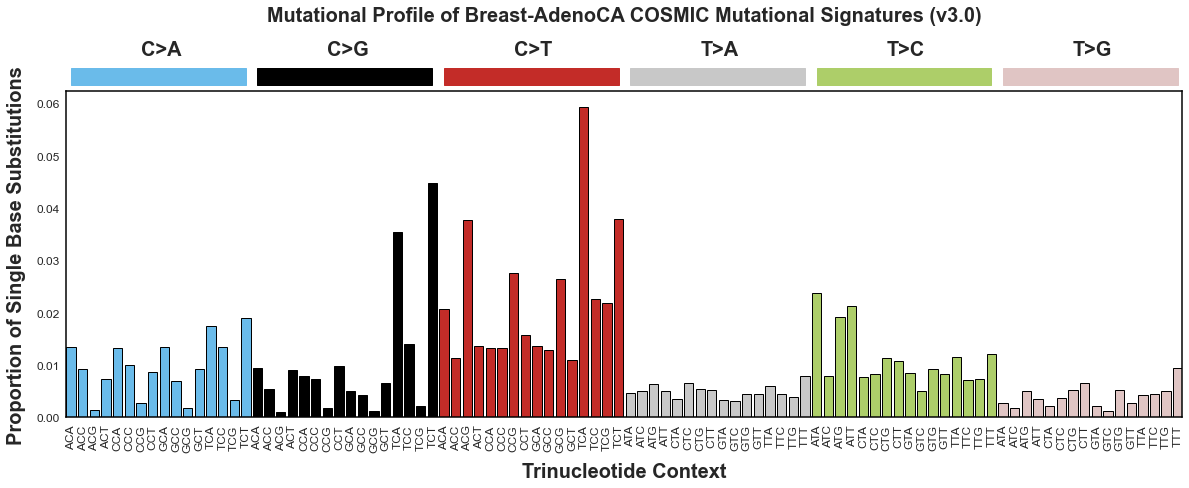

In [39]:
sbs_sig_plot("Breast-AdenoCA", real_sbs_breast_adenoca_mean)

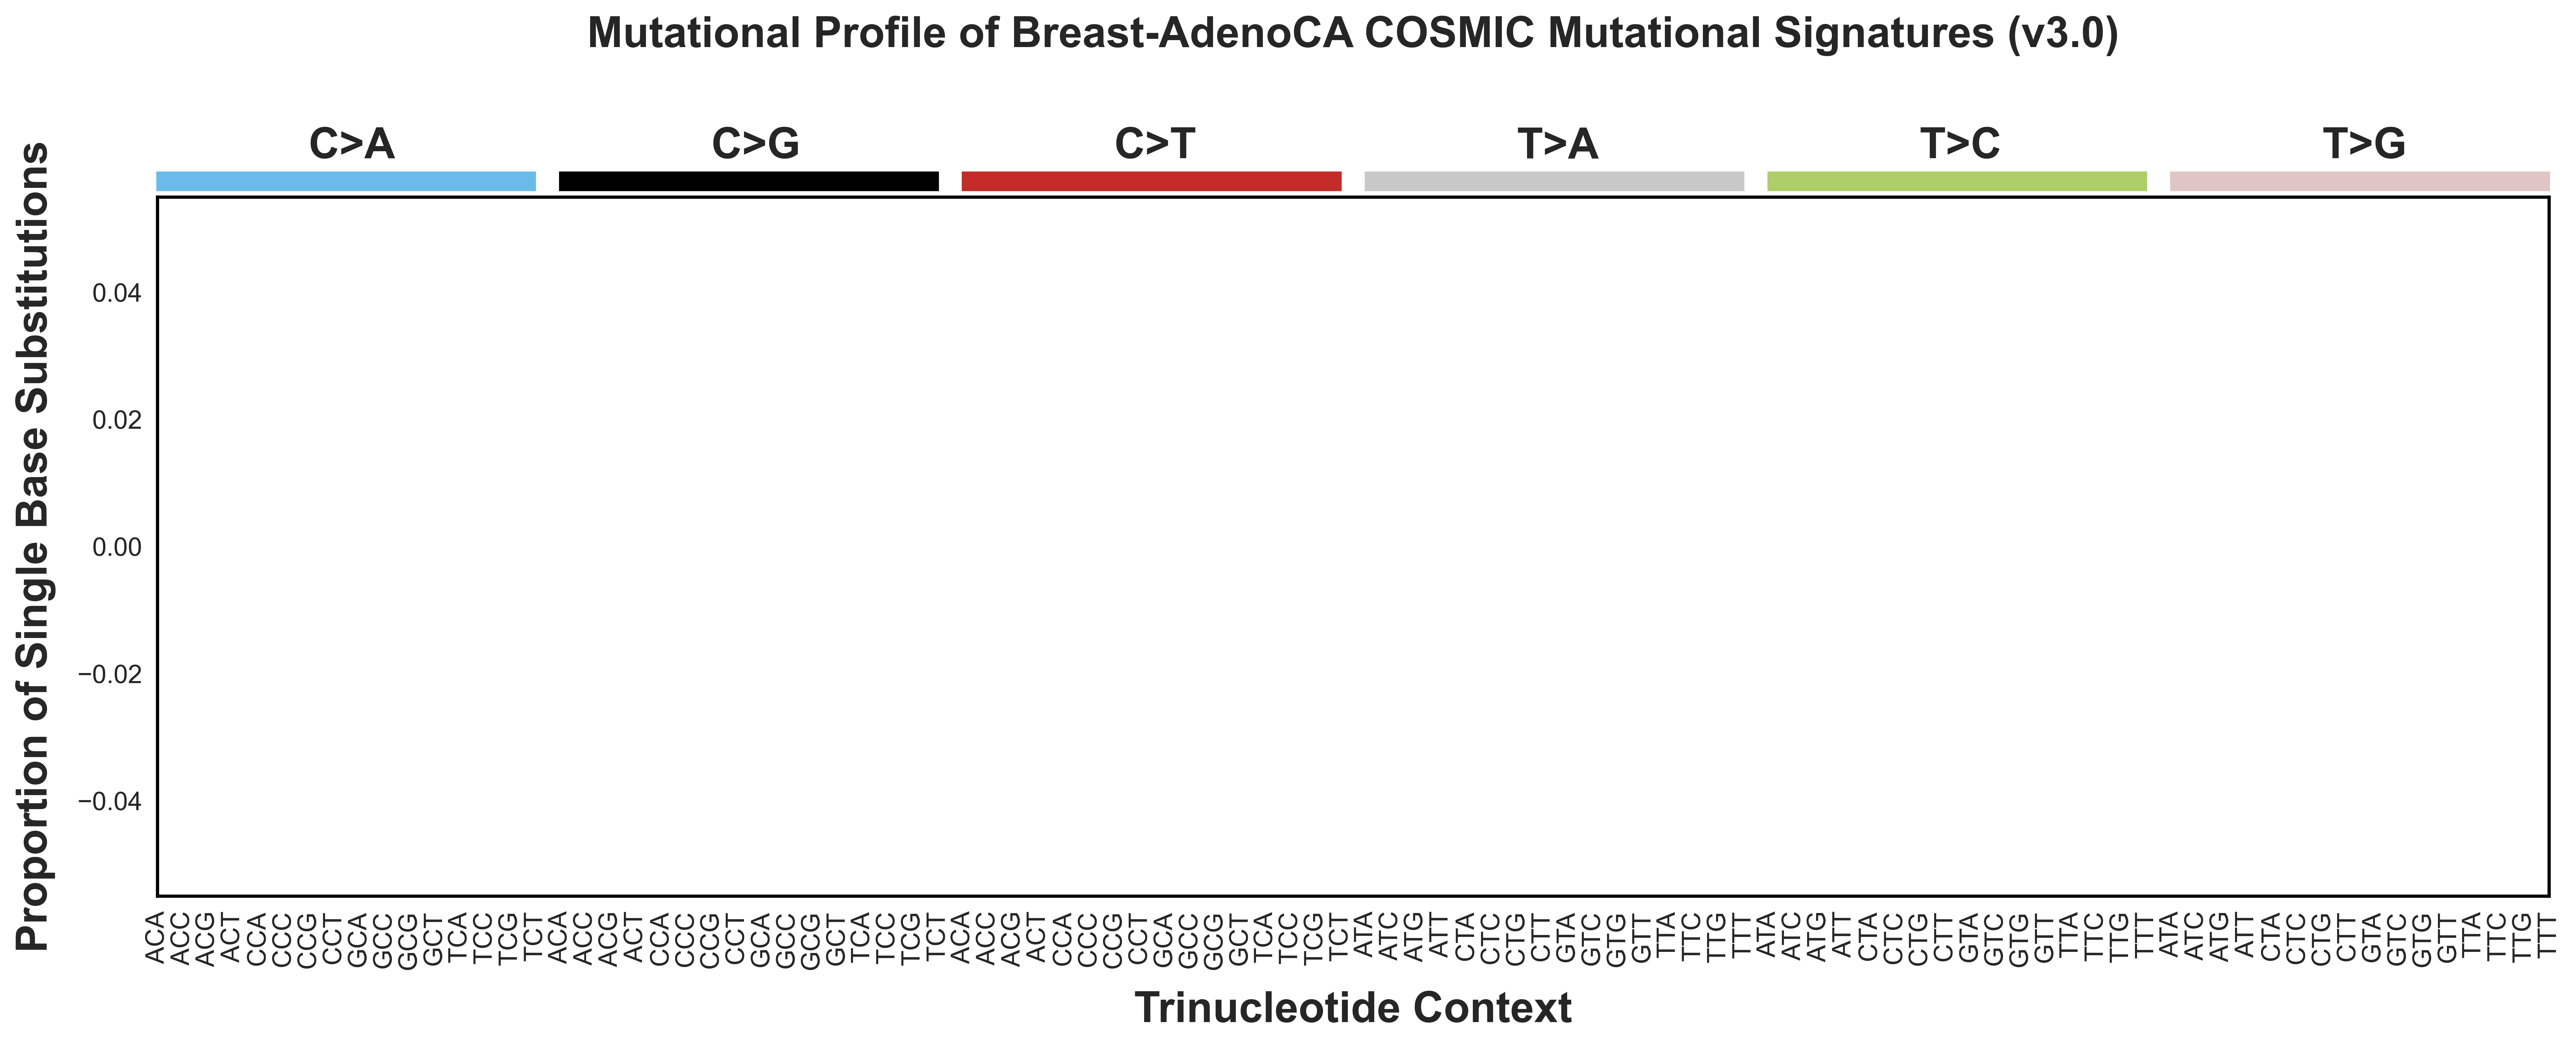

In [40]:
sbs_sig_plot("Breast-AdenoCA", simulated_sbs_breast_adenoca_mean)

In [ ]:
sbs_boxplot(simulated_sbs_breast_adenoca_df)

In [ ]:
sbs_boxplot(real_sbs_breast_adenoca_df)

In [ ]:
cosine_similarity([real_sbs_breast_adenoca_mean, simulated_sbs_breast_adenoca_mean])

In [ ]:
cosine_similarity([real_sbs_breast_adenoca_median, simulated_sbs_breast_adenoca_median])

In [ ]:
wilcoxon(real_sbs_breast_adenoca_mean, simulated_sbs_breast_adenoca_mean)


In [ ]:
wilcoxon(real_sbs_breast_adenoca_median, simulated_sbs_breast_adenoca_median)


In [ ]:
ranksums(real_sbs_breast_adenoca_mean, simulated_sbs_breast_adenoca_mean)

In [ ]:
dbs_sig_plot("Breast-AdenoCA", real_dbs_breast_adenoca_mean)

In [ ]:
dbs_sig_plot("Breast-AdenoCA", simulated_dbs_breast_adenoca_mean)

In [ ]:
cosine_similarity([real_dbs_breast_adenoca_mean, simulated_dbs_breast_adenoca_mean])

In [ ]:
wilcoxon(real_dbs_breast_adenoca_mean, simulated_dbs_breast_adenoca_mean)


In [ ]:
ranksums(real_dbs_breast_adenoca_mean, simulated_dbs_breast_adenoca_mean)

In [ ]:
ins_sig_plot("Breast-AdenoCA", real_ins_breast_adenoca_mean)

In [ ]:
ins_sig_plot("Breast-AdenoCA", simulated_ins_breast_adenoca_mean)

In [ ]:
cosine_similarity([real_ins_breast_adenoca_mean, simulated_ins_breast_adenoca_mean])

In [ ]:
cosine_similarity([real_ins_breast_adenoca_median, simulated_ins_breast_adenoca_median])

In [ ]:
wilcoxon(real_ins_breast_adenoca_mean, simulated_ins_breast_adenoca_mean)


In [ ]:
wilcoxon(real_ins_breast_adenoca_median, simulated_ins_breast_adenoca_median)


In [ ]:
ranksums(real_ins_breast_adenoca_mean, simulated_ins_breast_adenoca_mean)

In [ ]:
del_sig_plot("Breast-AdenoCA", real_del_breast_adenoca_mean)

In [ ]:
del_sig_plot("Breast-AdenoCA", simulated_del_breast_adenoca_mean)

In [ ]:
cosine_similarity([real_del_breast_adenoca_mean, simulated_del_breast_adenoca_mean])

In [ ]:
wilcoxon(real_del_breast_adenoca_mean, simulated_del_breast_adenoca_mean)


In [ ]:
ranksums(real_del_breast_adenoca_mean, simulated_del_breast_adenoca_mean)

In [ ]:
cosine_similarity_heatmap(cancer_type="Breast-AdenoCA", 
                          matrix1=simulated_sbs_breast_adenoca_df.T, 
                          matrix2=real_sbs_breast_adenoca_df.T,
                          mut_type="sbs",
                          cmap="Blues_r")

In [ ]:
cosine_similarity_heatmap(cancer_type="Breast-AdenoCA", 
                          matrix1=simulated_dbs_breast_adenoca_df.T.fillna(0), 
                          matrix2=real_dbs_breast_adenoca_df.T.fillna(0), 
                          mut_type="dbs",
                          cmap="Reds_r")

In [ ]:
cosine_similarity_heatmap(cancer_type="Breast-AdenoCA", 
                          matrix1=simulated_ins_breast_adenoca_df.T, 
                          matrix2=real_ins_breast_adenoca_df.T, 
                          mut_type="indel",
                          cmap="Greens_r")

In [ ]:
cosine_similarity_heatmap(cancer_type="Breast-AdenoCA", 
                          matrix1=simulated_del_breast_adenoca_df.T, 
                          matrix2=real_del_breast_adenoca_df.T, 
                          mut_type="indel",
                          cmap="Purples_r")

## Liver-Hepatocellular Carcinoma

In [ ]:
simulated_sbs_liver_hcc_df = simulated_sbs_data(500,1000)
simulated_dbs_liver_hcc_df = simulated_dbs_data(500,1000)
simulated_ins_liver_hcc_df = simulated_ins_data(500,1000)
simulated_del_liver_hcc_df = simulated_del_data(500,1000)

In [ ]:
simulated_sbs_liver_hcc_df = simulated_sbs_liver_hcc_df.div(simulated_sbs_liver_hcc_df.sum(axis=0), axis=1)
simulated_dbs_liver_hcc_df = simulated_dbs_liver_hcc_df.div(simulated_dbs_liver_hcc_df.sum(axis=0), axis=1)
simulated_ins_liver_hcc_df = simulated_ins_liver_hcc_df.div(simulated_ins_liver_hcc_df.sum(axis=0), axis=1).fillna(0)
simulated_del_liver_hcc_df = simulated_del_liver_hcc_df.div(simulated_del_liver_hcc_df.sum(axis=0), axis=1).fillna(0)

In [ ]:
simulated_sbs_liver_hcc_median = simulated_sbs_liver_hcc_df.median(axis=1).div(simulated_sbs_liver_hcc_df.median(axis=1).sum())
simulated_dbs_liver_hcc_median = simulated_dbs_liver_hcc_df.median(axis=1).div(simulated_dbs_liver_hcc_df.median(axis=1).sum())
simulated_ins_liver_hcc_median = simulated_ins_liver_hcc_df.median(axis=1).div(simulated_ins_liver_hcc_df.median(axis=1).sum())
simulated_del_liver_hcc_median = simulated_del_liver_hcc_df.median(axis=1).div(simulated_del_liver_hcc_df.median(axis=1).sum())

In [ ]:
simulated_sbs_liver_hcc_mean = simulated_sbs_liver_hcc_df.mean(axis=1).div(simulated_sbs_liver_hcc_df.mean(axis=1).sum())
simulated_dbs_liver_hcc_mean = simulated_dbs_liver_hcc_df.mean(axis=1).div(simulated_dbs_liver_hcc_df.mean(axis=1).sum())
simulated_ins_liver_hcc_mean = simulated_ins_liver_hcc_df.mean(axis=1).div(simulated_ins_liver_hcc_df.mean(axis=1).sum())
simulated_del_liver_hcc_mean = simulated_del_liver_hcc_df.mean(axis=1).div(simulated_del_liver_hcc_df.mean(axis=1).sum())

In [ ]:
real_sbs_liver_hcc_df = real_sbs_data("Liver-HCC")
real_dbs_liver_hcc_df = real_dbs_data("Liver-HCC")
real_ins_liver_hcc_df = real_indel_data("Liver-HCC").copy().iloc[12:]
real_del_liver_hcc_df = real_indel_data("Liver-HCC").copy().iloc[:12]

In [ ]:
real_sbs_liver_hcc_df = real_sbs_liver_hcc_df.div(real_sbs_liver_hcc_df.sum(axis=0), axis=1)
real_dbs_liver_hcc_df = real_dbs_liver_hcc_df.div(real_dbs_liver_hcc_df.sum(axis=0), axis=1)
real_ins_liver_hcc_df = real_ins_liver_hcc_df.div(real_ins_liver_hcc_df.sum(axis=0), axis=1)
real_del_liver_hcc_df = real_del_liver_hcc_df.div(real_del_liver_hcc_df.sum(axis=0), axis=1)

In [ ]:
real_sbs_liver_hcc_mean = real_sbs_liver_hcc_df.mean(axis=1)
real_dbs_liver_hcc_mean = real_dbs_liver_hcc_df.mean(axis=1)
real_ins_liver_hcc_mean = real_ins_liver_hcc_df.mean(axis=1)
real_del_liver_hcc_mean = real_del_liver_hcc_df.mean(axis=1)

In [ ]:
real_sbs_liver_hcc_median = real_sbs_liver_hcc_df.median(axis=1)
real_dbs_liver_hcc_median = real_dbs_liver_hcc_df.median(axis=1)
real_ins_liver_hcc_median = real_ins_liver_hcc_df.median(axis=1)
real_del_liver_hcc_median = real_del_liver_hcc_df.median(axis=1)

In [ ]:
sbs_sig_plot("Liver-HCC", real_sbs_liver_hcc_mean)

In [ ]:
sbs_sig_plot("Liver-HCC", simulated_sbs_liver_hcc_mean)

In [ ]:
sbs_boxplot(real_sbs_liver_hcc_df)

In [ ]:
sbs_boxplot(simulated_sbs_liver_hcc_df)

In [ ]:
cosine_similarity([real_sbs_liver_hcc_mean, simulated_sbs_liver_hcc_mean])

In [ ]:
cosine_similarity([real_sbs_liver_hcc_median, simulated_sbs_liver_hcc_median])

In [ ]:
wilcoxon(real_sbs_liver_hcc_mean, simulated_sbs_liver_hcc_mean)


In [ ]:
wilcoxon(real_sbs_liver_hcc_median, simulated_sbs_liver_hcc_median)


In [ ]:
ranksums(real_sbs_liver_hcc_mean, simulated_sbs_liver_hcc_mean)

In [ ]:
dbs_sig_plot("Liver-HCC", real_dbs_liver_hcc_mean)

In [ ]:
dbs_sig_plot("Liver-HCC", simulated_dbs_liver_hcc_mean)

In [ ]:
cosine_similarity([real_dbs_liver_hcc_mean, simulated_dbs_liver_hcc_mean])

In [ ]:
cosine_similarity([real_dbs_liver_hcc_median, simulated_dbs_liver_hcc_median])

In [ ]:
wilcoxon(real_dbs_liver_hcc_mean, simulated_dbs_liver_hcc_mean)


In [ ]:
wilcoxon(real_dbs_liver_hcc_median, simulated_dbs_liver_hcc_median)


In [ ]:
ranksums(real_dbs_liver_hcc_mean, simulated_dbs_liver_hcc_mean)

In [ ]:
ins_sig_plot("Liver-HCC", real_ins_liver_hcc_mean)

In [ ]:
ins_sig_plot("Liver-HCC", simulated_ins_liver_hcc_mean)

In [ ]:
cosine_similarity([real_ins_liver_hcc_mean, simulated_ins_liver_hcc_mean])

In [ ]:
cosine_similarity([real_ins_liver_hcc_median, simulated_ins_liver_hcc_median])

In [ ]:
wilcoxon(real_ins_liver_hcc_mean, simulated_ins_liver_hcc_mean)


In [ ]:
wilcoxon(real_ins_liver_hcc_median, simulated_ins_liver_hcc_median)


In [ ]:
ranksums(real_ins_liver_hcc_mean, simulated_ins_liver_hcc_mean)

In [ ]:
del_sig_plot("Liver-HCC", real_del_liver_hcc_mean)

In [ ]:
del_sig_plot("Liver-HCC", simulated_del_liver_hcc_mean)

In [ ]:
cosine_similarity([real_del_liver_hcc_mean, simulated_del_liver_hcc_mean])

In [ ]:
cosine_similarity([real_del_liver_hcc_median, simulated_del_liver_hcc_median])

In [ ]:
wilcoxon(real_del_liver_hcc_mean, simulated_del_liver_hcc_mean)


In [ ]:
wilcoxon(real_del_liver_hcc_median, simulated_del_liver_hcc_median)


In [ ]:
ranksums(real_del_liver_hcc_mean, simulated_del_liver_hcc_mean)

In [ ]:
cosine_similarity_heatmap(cancer_type="Liver-HCC", 
                          matrix1=simulated_sbs_liver_hcc_df.T, 
                          matrix2=real_sbs_liver_hcc_df.T,
                          mut_type="sbs",
                          cmap="Blues_r")

In [ ]:
cosine_similarity_heatmap(cancer_type="Liver-HCC", 
                          matrix1=simulated_dbs_liver_hcc_df.T.fillna(0), 
                          matrix2=real_dbs_liver_hcc_df.T.fillna(0), 
                          mut_type="dbs",
                          cmap="Reds_r")

In [ ]:
cosine_similarity_heatmap(cancer_type="Liver-HCC", 
                          matrix1=simulated_ins_liver_hcc_df.T, 
                          matrix2=real_ins_liver_hcc_df.T, 
                          mut_type="indel",
                          cmap="Greens_r")

In [ ]:
cosine_similarity_heatmap(cancer_type="Liver-HCC", 
                          matrix1=simulated_del_liver_hcc_df.T, 
                          matrix2=real_del_liver_hcc_df.T, 
                          mut_type="indel",
                          cmap="Purples_r")

## Skin Melanoma

In [ ]:
simulated_sbs_skin_melanoma_df = simulated_sbs_data(1000,1500)
simulated_dbs_skin_melanoma_df = simulated_dbs_data(1000,1500)
simulated_ins_skin_melanoma_df = simulated_ins_data(1000,1500)
simulated_del_skin_melanoma_df = simulated_del_data(1000,1500)

In [ ]:
simulated_sbs_skin_melanoma_df = simulated_sbs_skin_melanoma_df.div(simulated_sbs_skin_melanoma_df.sum(axis=0), axis=1)
simulated_dbs_skin_melanoma_df = simulated_dbs_skin_melanoma_df.div(simulated_dbs_skin_melanoma_df.sum(axis=0), axis=1)
simulated_ins_skin_melanoma_df = simulated_ins_skin_melanoma_df.div(simulated_ins_skin_melanoma_df.sum(axis=0), axis=1).fillna(0)
simulated_del_skin_melanoma_df = simulated_del_skin_melanoma_df.div(simulated_del_skin_melanoma_df.sum(axis=0), axis=1).fillna(0)

In [ ]:
simulated_sbs_skin_melanoma_mean = simulated_sbs_skin_melanoma_df.mean(axis=1).div(simulated_sbs_skin_melanoma_df.mean(axis=1).sum())
simulated_dbs_skin_melanoma_mean = simulated_dbs_skin_melanoma_df.mean(axis=1).div(simulated_dbs_skin_melanoma_df.mean(axis=1).sum())
simulated_ins_skin_melanoma_mean = simulated_ins_skin_melanoma_df.mean(axis=1).div(simulated_ins_skin_melanoma_df.mean(axis=1).sum())
simulated_del_skin_melanoma_mean = simulated_del_skin_melanoma_df.mean(axis=1).div(simulated_del_skin_melanoma_df.mean(axis=1).sum())

In [ ]:
simulated_sbs_skin_melanoma_median = simulated_sbs_skin_melanoma_df.median(axis=1).div(simulated_sbs_skin_melanoma_df.median(axis=1).sum())
simulated_dbs_skin_melanoma_median = simulated_dbs_skin_melanoma_df.median(axis=1).div(simulated_dbs_skin_melanoma_df.median(axis=1).sum())
simulated_ins_skin_melanoma_median = simulated_ins_skin_melanoma_df.median(axis=1).div(simulated_ins_skin_melanoma_df.median(axis=1).sum())
simulated_del_skin_melanoma_median = simulated_del_skin_melanoma_df.median(axis=1).div(simulated_del_skin_melanoma_df.median(axis=1).sum())

In [ ]:
real_sbs_skin_melanoma_df = real_sbs_data("Skin-Melanoma")
real_dbs_skin_melanoma_df = real_dbs_data("Skin-Melanoma")
real_ins_skin_melanoma_df = real_indel_data("Skin-Melanoma").copy().iloc[12:]
real_del_skin_melanoma_df = real_indel_data("Skin-Melanoma").copy().iloc[:12]

In [ ]:
real_sbs_skin_melanoma_df = real_sbs_skin_melanoma_df.div(real_sbs_skin_melanoma_df.sum(axis=0), axis=1)
real_dbs_skin_melanoma_df = real_dbs_skin_melanoma_df.div(real_dbs_skin_melanoma_df.sum(axis=0), axis=1)
real_ins_skin_melanoma_df = real_ins_skin_melanoma_df.div(real_ins_skin_melanoma_df.sum(axis=0), axis=1)
real_del_skin_melanoma_df = real_del_skin_melanoma_df.div(real_del_skin_melanoma_df.sum(axis=0), axis=1)

In [ ]:
real_sbs_skin_melanoma_mean = real_sbs_skin_melanoma_df.mean(axis=1)
real_dbs_skin_melanoma_mean = real_dbs_skin_melanoma_df.mean(axis=1)
real_ins_skin_melanoma_mean = real_ins_skin_melanoma_df.mean(axis=1)
real_del_skin_melanoma_mean = real_del_skin_melanoma_df.mean(axis=1)

In [ ]:
real_sbs_skin_melanoma_median = real_sbs_skin_melanoma_df.median(axis=1)
real_dbs_skin_melanoma_median = real_dbs_skin_melanoma_df.median(axis=1)
real_ins_skin_melanoma_median = real_ins_skin_melanoma_df.median(axis=1)
real_del_skin_melanoma_median = real_del_skin_melanoma_df.median(axis=1)

In [ ]:
sbs_sig_plot("Skin-Melanoma", real_sbs_skin_melanoma_mean)

In [ ]:
sbs_sig_plot("Skin-Melanoma", simulated_sbs_skin_melanoma_mean)

In [ ]:
sbs_boxplot(real_sbs_skin_melanoma_df)

In [ ]:
sbs_boxplot(simulated_sbs_skin_melanoma_df)

In [ ]:
cosine_similarity([real_sbs_skin_melanoma_mean, simulated_sbs_skin_melanoma_mean])

In [ ]:
cosine_similarity([real_sbs_skin_melanoma_median, simulated_sbs_skin_melanoma_median])

In [ ]:
wilcoxon(real_sbs_skin_melanoma_mean, simulated_sbs_skin_melanoma_mean)


In [ ]:
wilcoxon(real_sbs_skin_melanoma_median, simulated_sbs_skin_melanoma_median)


In [ ]:
ranksums(real_sbs_skin_melanoma_mean, simulated_sbs_skin_melanoma_mean)

In [ ]:
dbs_sig_plot("Skin-Melanoma", real_dbs_skin_melanoma_mean)

In [ ]:
dbs_sig_plot("Skin-Melanoma", simulated_dbs_skin_melanoma_mean)

In [ ]:
cosine_similarity([real_dbs_skin_melanoma_mean, simulated_dbs_skin_melanoma_mean])

In [ ]:
cosine_similarity([real_dbs_skin_melanoma_median, simulated_dbs_skin_melanoma_median])

In [ ]:
wilcoxon(real_dbs_skin_melanoma_mean, simulated_dbs_skin_melanoma_mean)


In [ ]:
wilcoxon(real_dbs_skin_melanoma_median, simulated_dbs_skin_melanoma_median)


In [ ]:
ranksums(real_dbs_skin_melanoma_mean, simulated_dbs_skin_melanoma_mean)

In [ ]:
ins_sig_plot("Skin-Melanoma", real_ins_skin_melanoma_mean)

In [ ]:
ins_sig_plot("Skin-Melanoma", simulated_ins_skin_melanoma_mean)

In [ ]:
cosine_similarity([real_ins_skin_melanoma_mean, simulated_ins_skin_melanoma_mean])

In [ ]:
cosine_similarity([real_ins_skin_melanoma_median, simulated_ins_skin_melanoma_median])

In [ ]:
wilcoxon(real_ins_skin_melanoma_mean, simulated_ins_skin_melanoma_mean)


In [ ]:
wilcoxon(real_ins_skin_melanoma_median, simulated_ins_skin_melanoma_median)


In [ ]:
ranksums(real_ins_skin_melanoma_mean, simulated_ins_skin_melanoma_mean)

In [ ]:
del_sig_plot("Skin-Melanoma", real_del_skin_melanoma_mean)

In [ ]:
del_sig_plot("Skin-Melanoma", simulated_del_skin_melanoma_mean)

In [ ]:
cosine_similarity([real_del_skin_melanoma_mean, simulated_del_skin_melanoma_mean])

In [ ]:
cosine_similarity([real_del_skin_melanoma_median, simulated_del_skin_melanoma_median])

In [ ]:
wilcoxon(real_del_skin_melanoma_mean, simulated_del_skin_melanoma_mean)


In [ ]:
wilcoxon(real_del_skin_melanoma_median, simulated_del_skin_melanoma_median)


In [ ]:
ranksums(real_del_skin_melanoma_mean, simulated_del_skin_melanoma_mean)

In [ ]:
cosine_similarity_heatmap(cancer_type="Skin-Melanoma", 
                          matrix1=simulated_sbs_skin_melanoma_df.T, 
                          matrix2=real_sbs_skin_melanoma_df.T,
                          mut_type="sbs",
                          cmap="Blues_r")

In [ ]:
cosine_similarity_heatmap(cancer_type="Skin-Melanoma", 
                          matrix1=simulated_dbs_skin_melanoma_df.T.fillna(0), 
                          matrix2=real_dbs_skin_melanoma_df.T.fillna(0), 
                          mut_type="dbs",
                          cmap="Reds_r")

In [ ]:
cosine_similarity_heatmap(cancer_type="Skin-Melanoma", 
                          matrix1=simulated_ins_skin_melanoma_df.T, 
                          matrix2=real_ins_skin_melanoma_df.T, 
                          mut_type="indel",
                          cmap="Greens_r")

In [ ]:
cosine_similarity_heatmap(cancer_type="Skin-Melanoma", 
                          matrix1=simulated_del_skin_melanoma_df.T, 
                          matrix2=real_del_skin_melanoma_df.T, 
                          mut_type="indel",
                          cmap="Purples_r")

# Test using Non-Human Genomic Sequences as Input

In [42]:
pyrimidine_trinucleotides = sorted(list(set(sbs_prop_data['SubType'])))

### Rattus norvegicus

In [44]:
with open("/Users/davidchen/Documents/GitHub/Reference_Genome/Rattus_norvegicus.Rnor_6.0.dna.chromosome.12.fasta") as fp:
    for name, seq in read_fasta(fp):
        rat_chr_12 = str(seq)

In [45]:
rat_chr_12_3mers = count_kmers(data=rat_chr_12, k=3)

In [46]:
rat_chr_12_total = sum([rat_chr_12_3mers[x] for x in pyrimidine_trinucleotides])

### GChr38 Chromosome 15

In [47]:
with open("/Users/davidchen/Documents/GitHub/SomaticSiMu/Reference_genome/GRCh38_Chromosome_15.fasta") as fp:
    for name, seq in read_fasta(fp):
        human_chr_15 = str(seq)

In [48]:
human_chr_15_3mers = count_kmers(data=human_chr_15, k=3)

In [49]:
human_chr_15_total = sum([human_chr_15_3mers[x] for x in pyrimidine_trinucleotides])

### Arabidopsis thaliana

In [50]:
with open("/Users/davidchen/Documents/GitHub/Reference_Genome/Arabidopsis_thaliana.TAIR10.dna.chromosome.1.fasta") as fp:
    for name, seq in read_fasta(fp):
        arabidopsis_chr_1 = str(seq)

In [51]:
arabidopsis_chr_1_3mers = count_kmers(data=arabidopsis_chr_1, k=3)

In [52]:
arabidopsis_chr_1_total = sum([arabidopsis_chr_1_3mers[x] for x in pyrimidine_trinucleotides])

### GChr38 Chromosome 15

In [53]:
with open("/Users/davidchen/Documents/GitHub/SomaticSiMu/Reference_genome/Homo_sapiens.GRCh38.dna.chromosome.22.fasta") as fp:
    for name, seq in read_fasta(fp):
        human_chr_22 = str(seq)

In [54]:
human_chr_22_3mers = count_kmers(data=human_chr_22, k=3)

In [55]:
human_chr_22_total = sum([human_chr_22_3mers[x] for x in pyrimidine_trinucleotides])

### K-mer Proportions

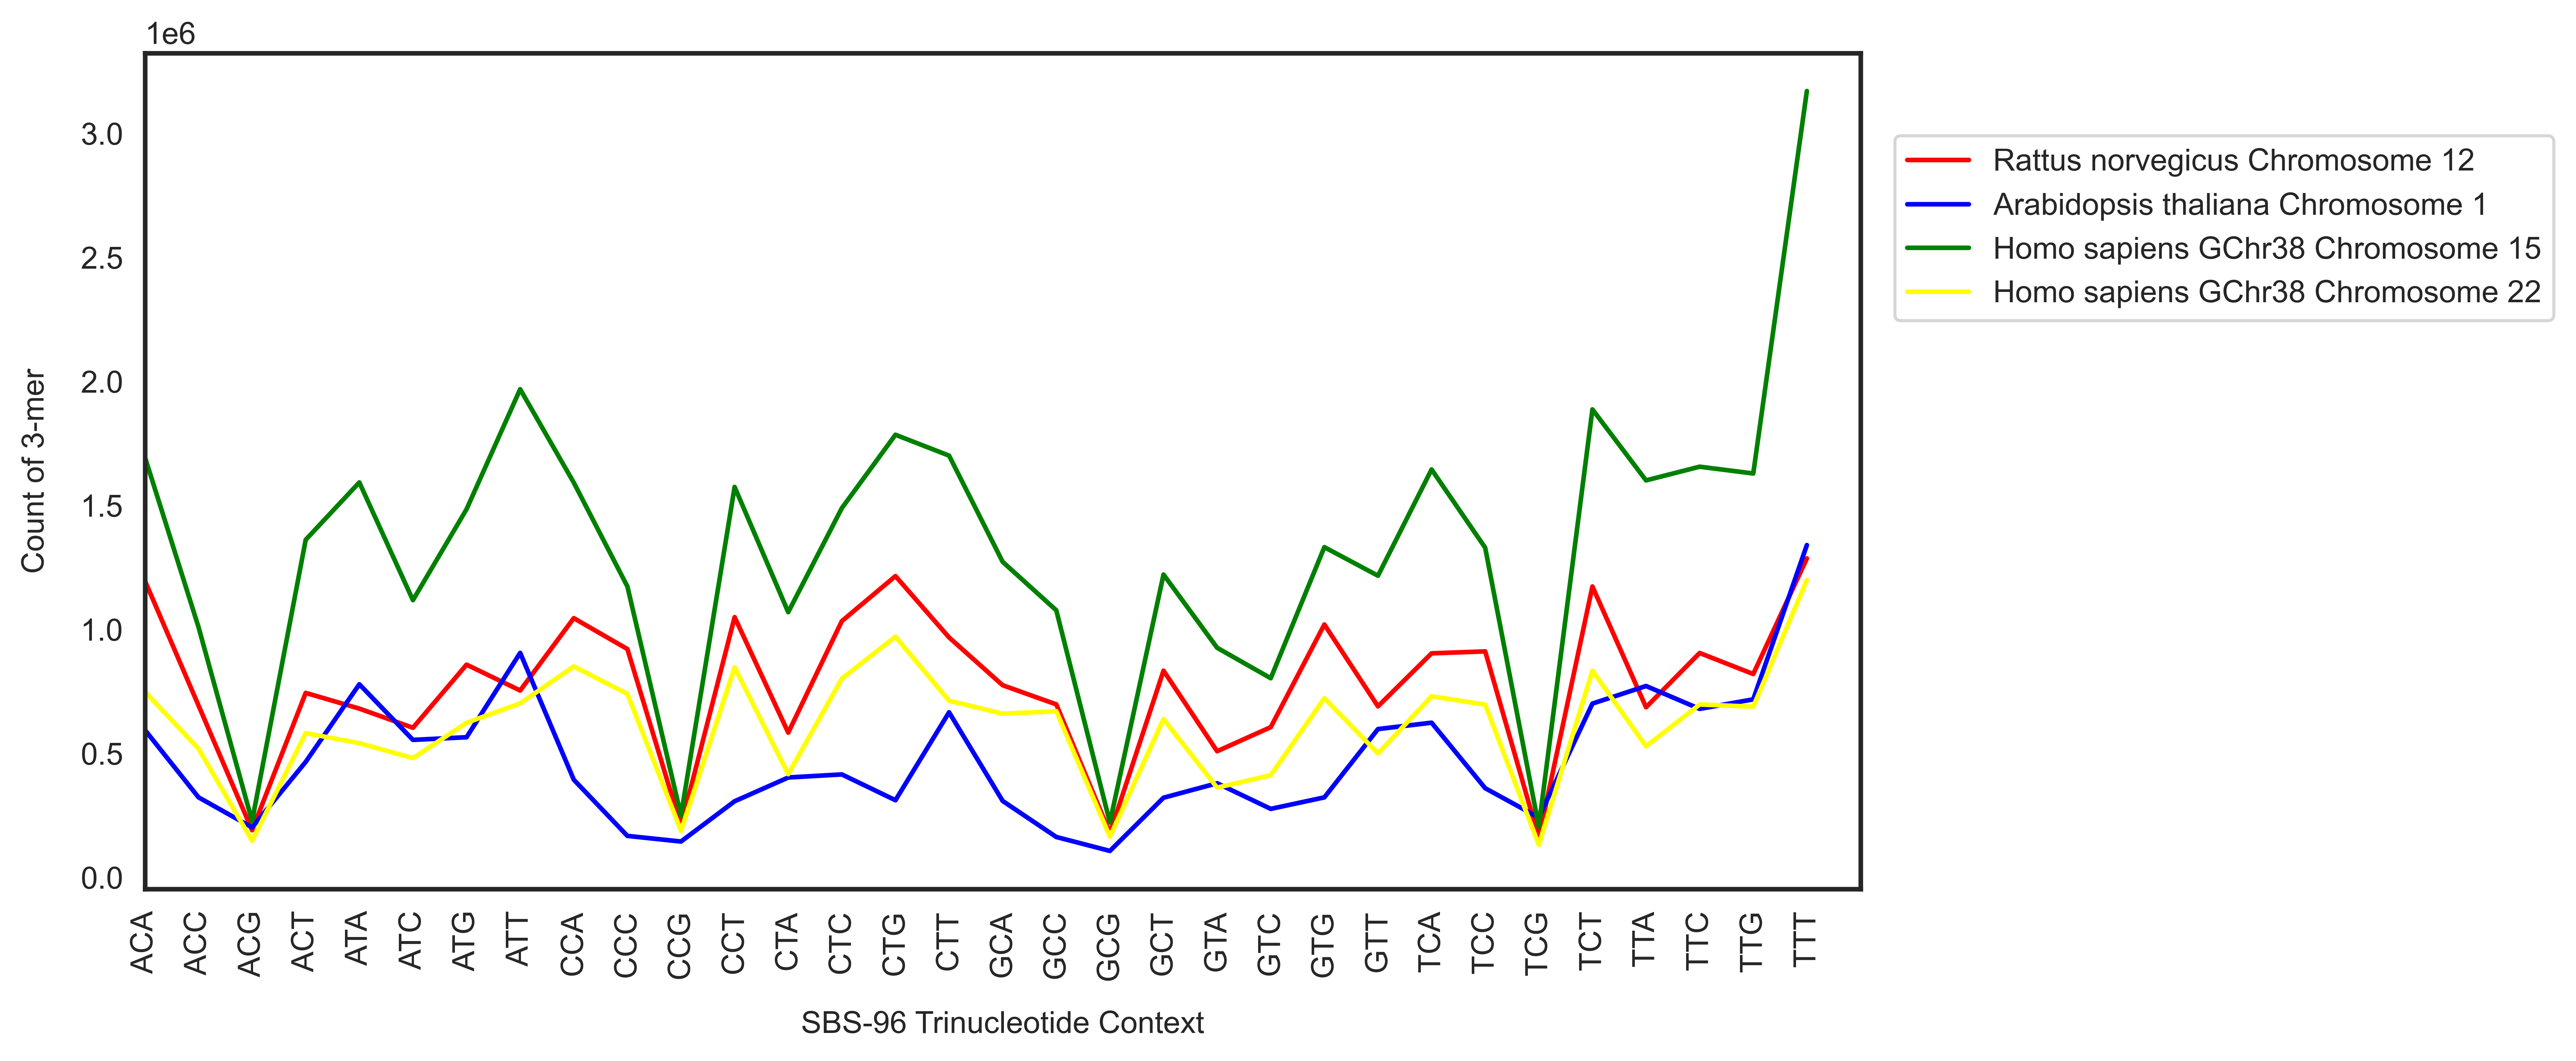

In [155]:
fig = plt.figure(figsize=(10,5))
ax = plt.axes()

#rat_kmer = [rat_chr_12_3mers[x]/rat_chr_12_total for x in pyrimidine_trinucleotides]
rat_kmer = [rat_chr_12_3mers[x] for x in pyrimidine_trinucleotides]
ax.plot(range(32), rat_kmer, c="red", label="Rattus norvegicus Chromosome 12")

#arabidopsis_kmer = [arabidopsis_chr_1_3mers[x]/arabidopsis_chr_1_total for x in pyrimidine_trinucleotides]
arabidopsis_kmer = [arabidopsis_chr_1_3mers[x] for x in pyrimidine_trinucleotides]
ax.plot(range(32), arabidopsis_kmer, c="blue", label="Arabidopsis thaliana Chromosome 1")

#human15_kmer = [human_chr_15_3mers[x]/human_chr_15_total for x in pyrimidine_trinucleotides]
human15_kmer = [human_chr_15_3mers[x] for x in pyrimidine_trinucleotides]
ax.plot(range(32), human15_kmer, c="green", label="Homo sapiens GChr38 Chromosome 15")

#human22_kmer = [human_chr_22_3mers[x]/human_chr_22_total for x in pyrimidine_trinucleotides]
human22_kmer = [human_chr_22_3mers[x] for x in pyrimidine_trinucleotides]
ax.plot(range(32), human22_kmer, c="yellow", label="Homo sapiens GChr38 Chromosome 22")

ax.set_xlim(0,32)
ax.set_xticks(range(32))
ax.set_xticklabels(pyrimidine_trinucleotides, size=10, rotation=90)
ax.set_xlabel("SBS-96 Trinucleotide Context", labelpad=10)
ax.set_ylabel("Count of 3-mer", labelpad=10)
plt.legend(loc=(1.02,0.68))
plt.show()

### Benchmark

In [67]:
simulated_rattus_sbs_skin_melanoma_df = simulated_data(folder="Frequency_Table_Rattus", cancer="Skin", mut_type="sbs")
#simulated_rattus_sbs_skin_melanoma_df = simulated_rattus_sbs_skin_melanoma_df.div(simulated_rattus_sbs_skin_melanoma_df.sum(axis=0), axis=1)
simulated_rattus_sbs_skin_melanoma_mean = simulated_rattus_sbs_skin_melanoma_df.mean(axis=1).div(simulated_rattus_sbs_skin_melanoma_df.mean(axis=1).sum())

In [68]:
simulated_arabidopsis_sbs_skin_melanoma_df = simulated_data(folder="Frequency_Table_Arabidopsis", cancer="Skin", mut_type="sbs")
#simulated_arabidopsis_sbs_skin_melanoma_df = simulated_arabidopsis_sbs_skin_melanoma_df.div(simulated_arabidopsis_sbs_skin_melanoma_df.sum(axis=0), axis=1)
simulated_arabidopsis_sbs_skin_melanoma_mean = simulated_arabidopsis_sbs_skin_melanoma_df.mean(axis=1).div(simulated_arabidopsis_sbs_skin_melanoma_df.mean(axis=1).sum())

In [69]:
simulated_Chr15_sbs_skin_melanoma_df = simulated_data(folder="Frequency_Table_Chr15", cancer="Skin", mut_type="sbs")
#simulated_Chr15_sbs_skin_melanoma_df = simulated_Chr15_sbs_skin_melanoma_df.div(simulated_Chr15_sbs_skin_melanoma_df.sum(axis=0), axis=1)
simulated_Chr15_sbs_skin_melanoma_mean = simulated_Chr15_sbs_skin_melanoma_df.mean(axis=1).div(simulated_Chr15_sbs_skin_melanoma_df.mean(axis=1).sum())

In [70]:
simulated_Chr22_sbs_skin_melanoma_df = simulated_data(folder="Frequency_Table_Chr22", cancer="Skin-Melanoma", mut_type="sbs")
#simulated_Chr22_sbs_skin_melanoma_df = simulated_Chr22_sbs_skin_melanoma_df.div(simulated_Chr22_sbs_skin_melanoma_df.sum(axis=0), axis=1)
simulated_Chr22_sbs_skin_melanoma_mean = simulated_Chr22_sbs_skin_melanoma_df.mean(axis=1).div(simulated_Chr22_sbs_skin_melanoma_df.mean(axis=1).sum())

In [156]:
def comparison_benchmark(subtype):
    
    index = list(sbs_prop_data[sbs_prop_data['SubType'] == subtype].index)
    fig, ((ax1, ax2, ax3), (ax5, ax6, ax7)) = plt.subplots(2, 3, figsize=(5,5), sharey="row")

    flierprops = dict(markerfacecolor='r', markersize=1)

    ax5.bar(1, rat_kmer[pyrimidine_trinucleotides.index(subtype)])
    ax5.set_xticklabels([])
    ax5.set_ylabel("Count of " + subtype + " in Reference Sequence", size=6)
    
    ax1.set_title("Rattus norvegicus", size=6)
    ax1.boxplot([simulated_rattus_sbs_skin_melanoma_df.iloc[index[0],], 
                simulated_rattus_sbs_skin_melanoma_df.iloc[index[1],], 
                simulated_rattus_sbs_skin_melanoma_df.iloc[index[2],]], showfliers=True,flierprops=flierprops)
    ax1.set_xticks(range(1, 4))
    ax1.set_xticklabels([subtype[0] + "_" + list(sbs_prop_data.iloc[index,:]['Type'])[x] + "_" + subtype[2]  for x in range(3)], rotation=45, size=6)   
    ax1.set_ylabel("Mutation Count", size=6)
    
    ax6.bar(1, arabidopsis_kmer[pyrimidine_trinucleotides.index(subtype)])
    ax6.set_xticklabels([])
    ax2.set_title("Arabidopsis thaliana", size=6)
    ax2.boxplot([simulated_arabidopsis_sbs_skin_melanoma_df.iloc[index[0],], 
                simulated_arabidopsis_sbs_skin_melanoma_df.iloc[index[1],], 
                simulated_arabidopsis_sbs_skin_melanoma_df.iloc[index[2],]], showfliers=True,flierprops=flierprops)
    ax2.set_xticks(range(1, 4))
    ax2.set_xticklabels([subtype[0] + "_" + list(sbs_prop_data.iloc[index,:]['Type'])[x] + "_" + subtype[2]  for x in range(3)], rotation=45, size=6)   


    ax7.bar(1, human15_kmer[pyrimidine_trinucleotides.index(subtype)])
    ax7.set_xticklabels([])
    ax3.set_title("Homo sapiens Chr.15", size=6)
    ax3.boxplot([simulated_Chr15_sbs_skin_melanoma_df.iloc[index[0],], 
                simulated_Chr15_sbs_skin_melanoma_df.iloc[index[1],], 
                simulated_Chr15_sbs_skin_melanoma_df.iloc[index[2],]], showfliers=True,flierprops=flierprops)
    ax3.set_xticks(range(1, 4))
    ax3.set_xticklabels([subtype[0] + "_" + list(sbs_prop_data.iloc[index,:]['Type'])[x] + "_" + subtype[2]  for x in range(3)], rotation=45, size=6)   

    
    plt.tight_layout()
    plt.show()

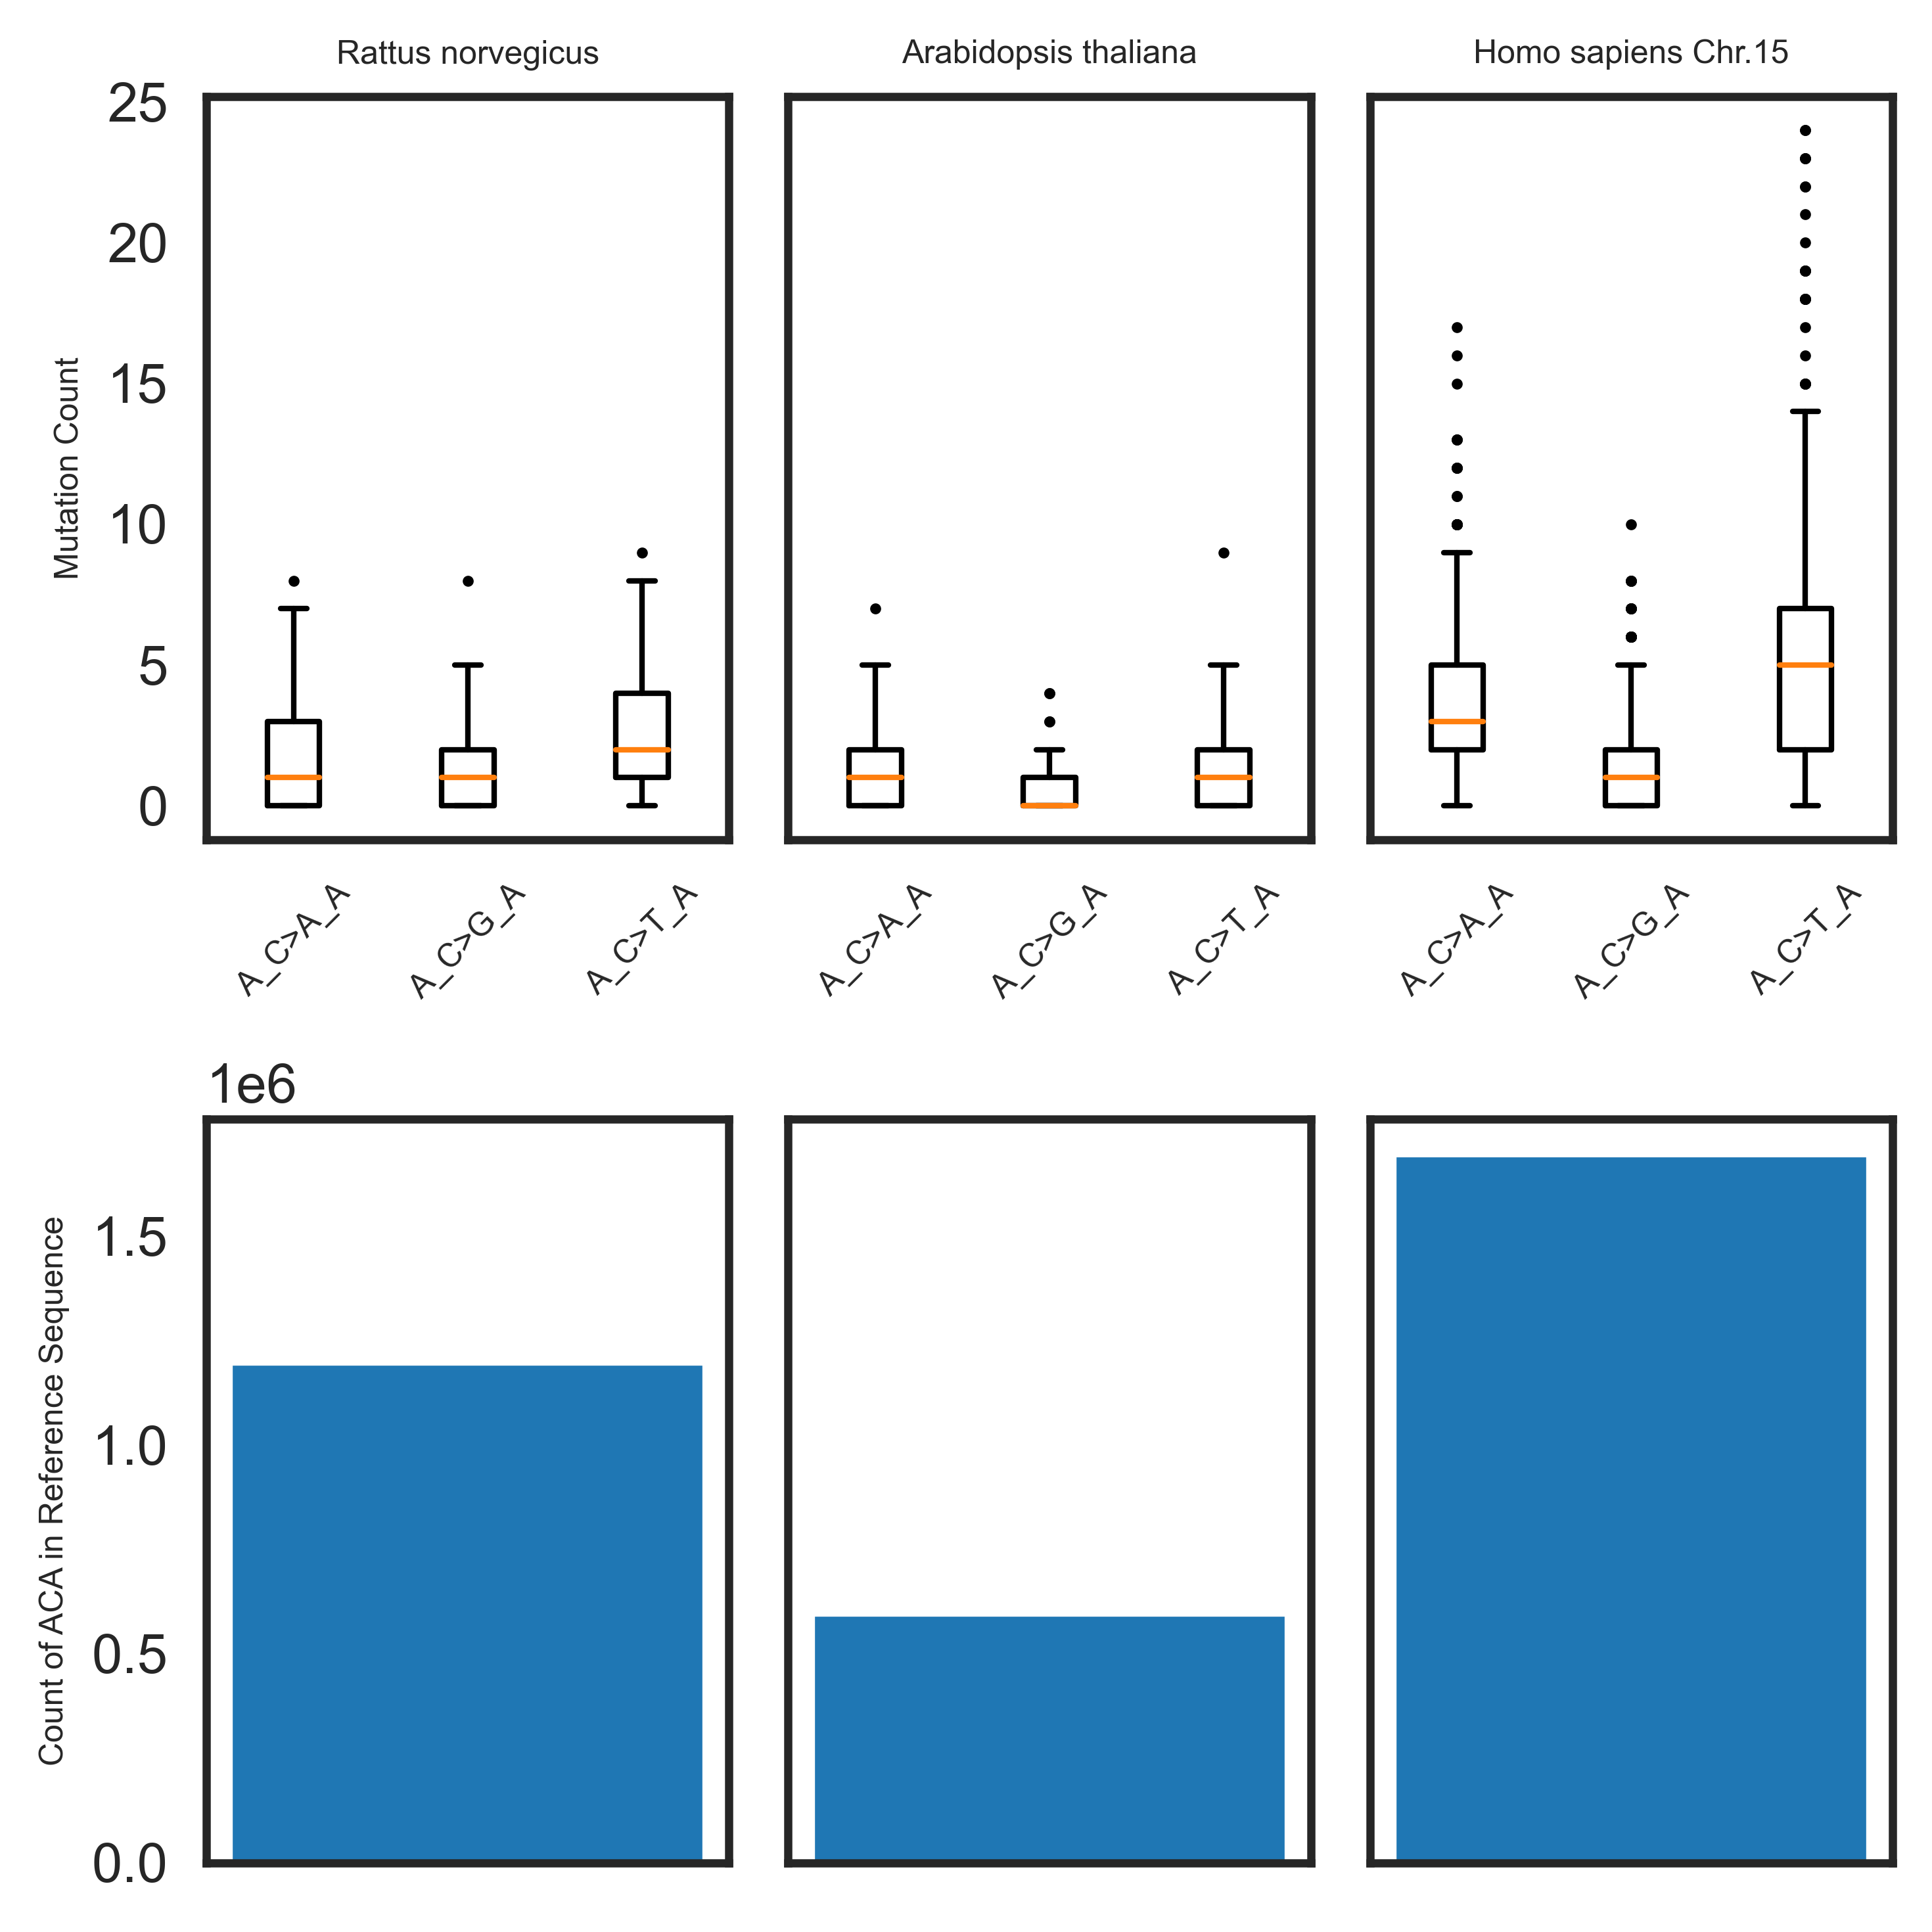

In [157]:
comparison_benchmark(subtype="ACA")

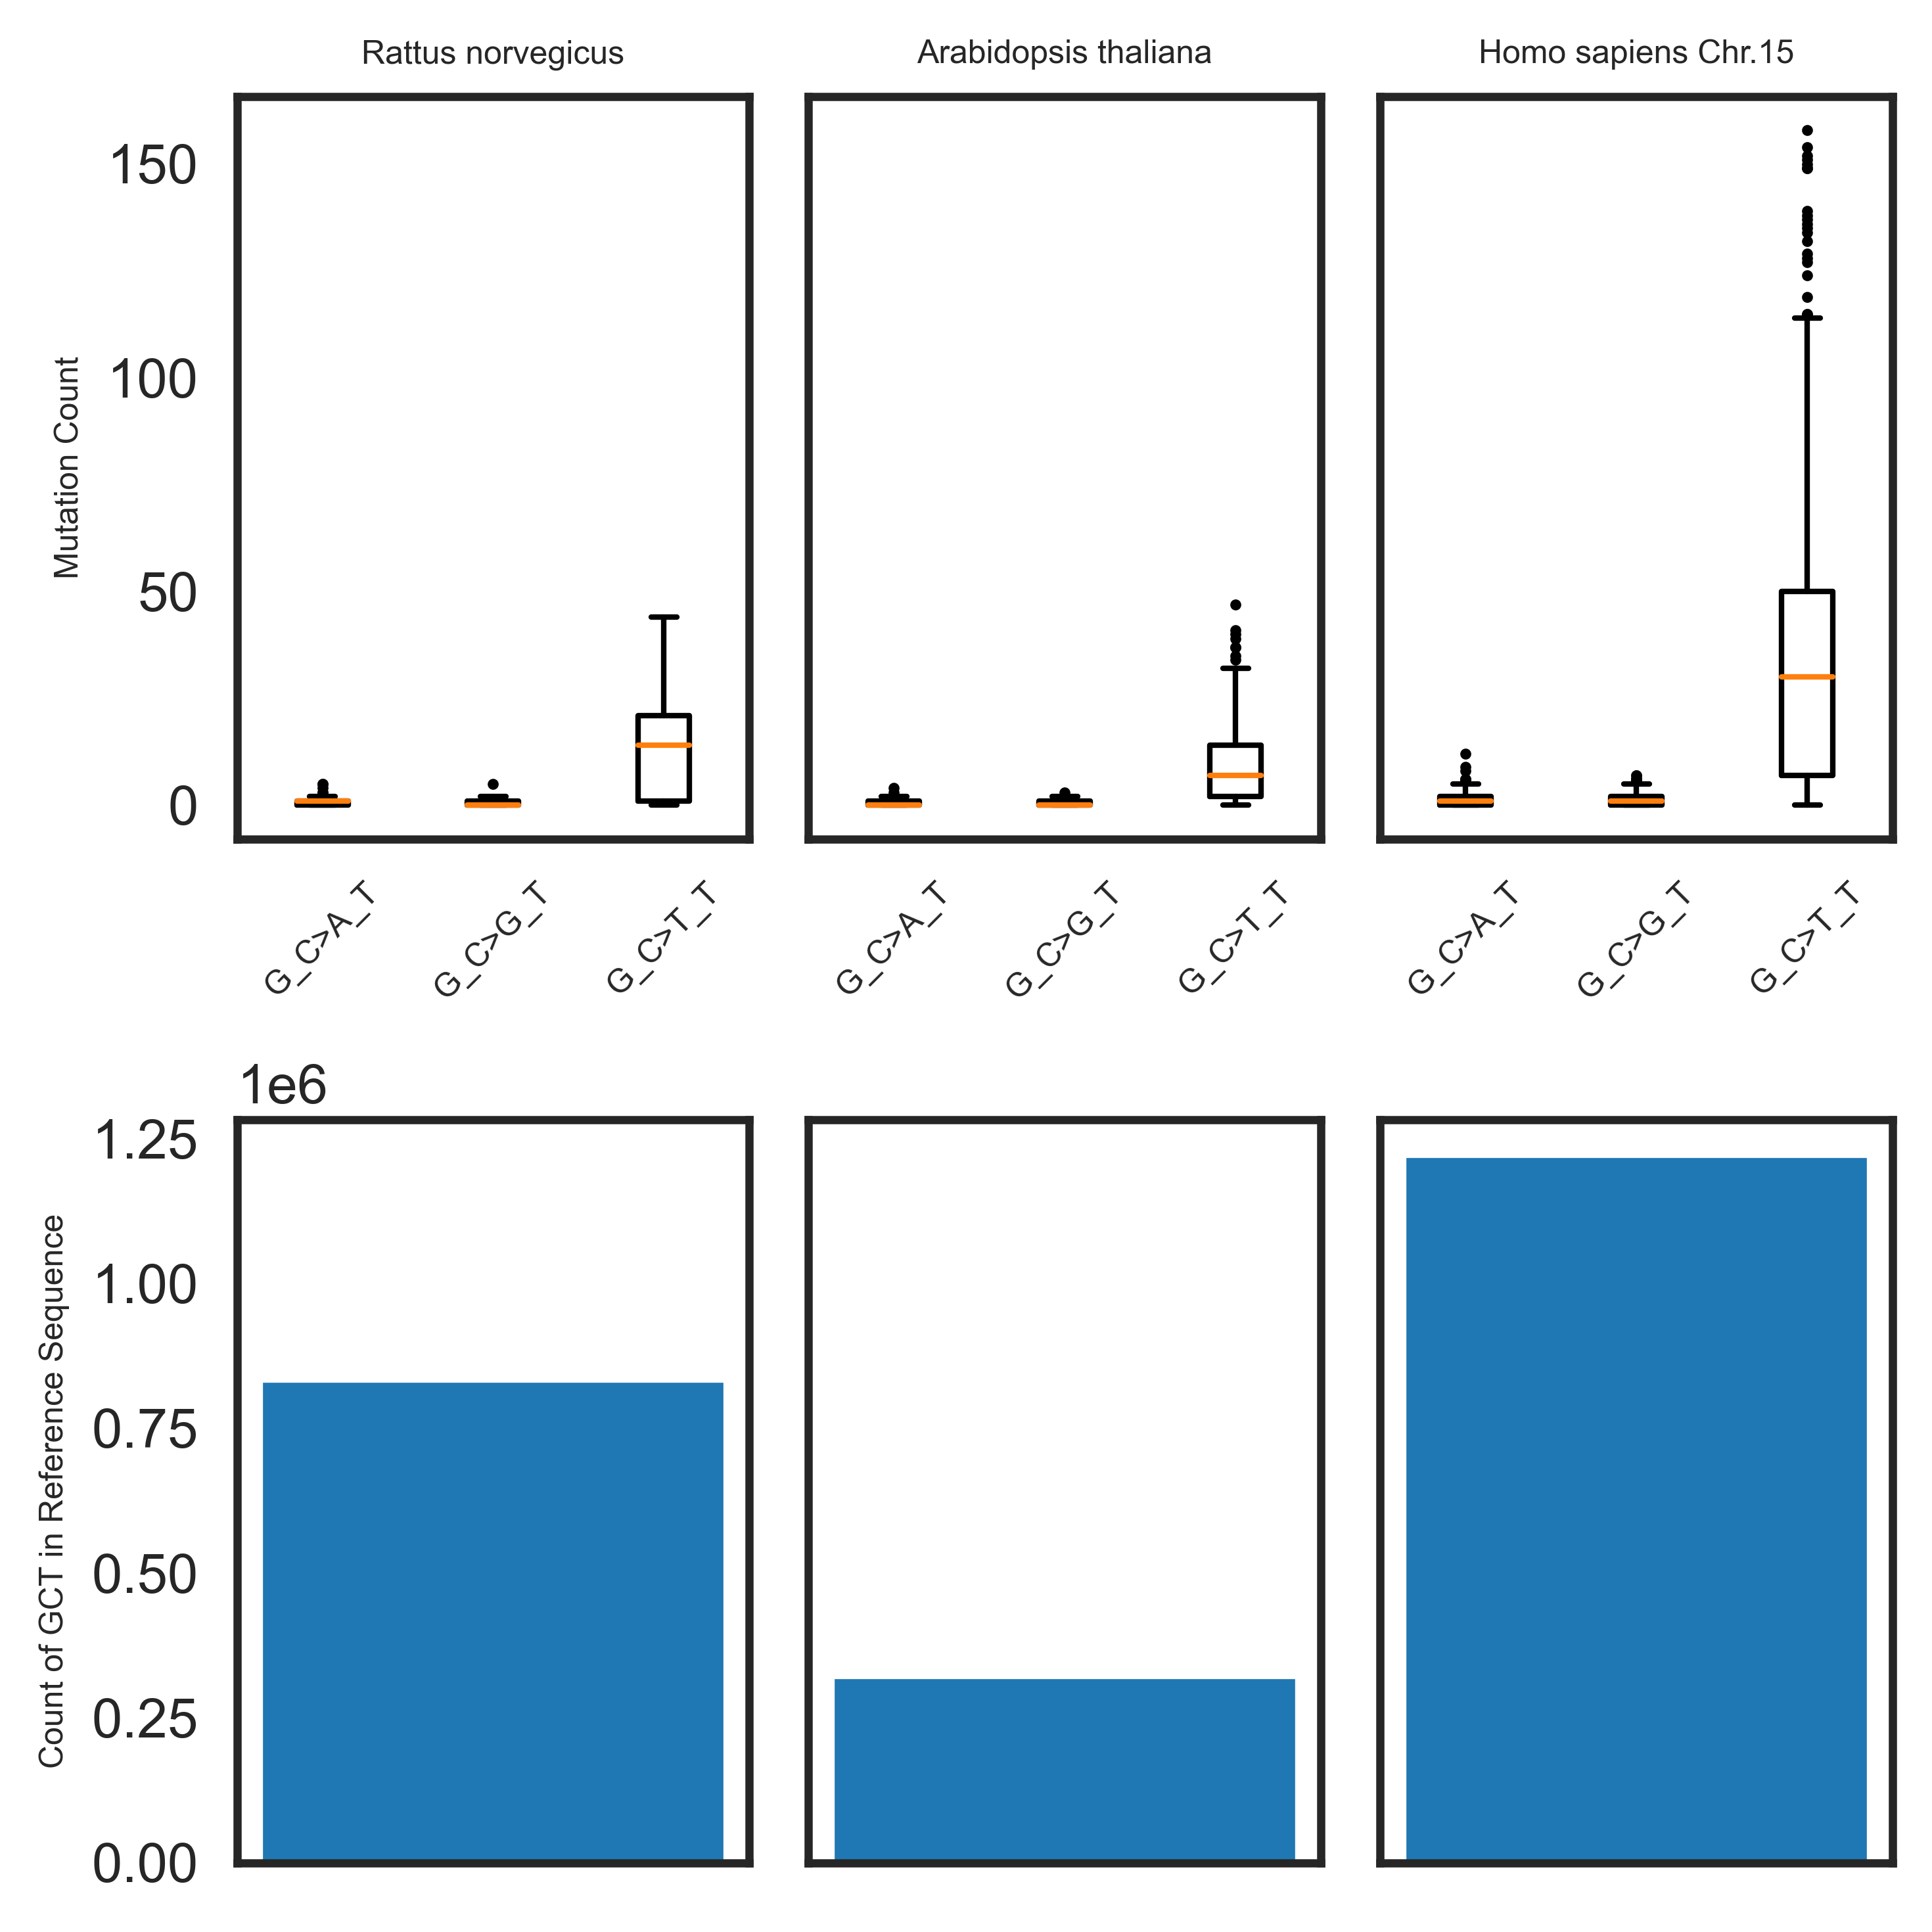

In [158]:
comparison_benchmark(subtype="GCT")

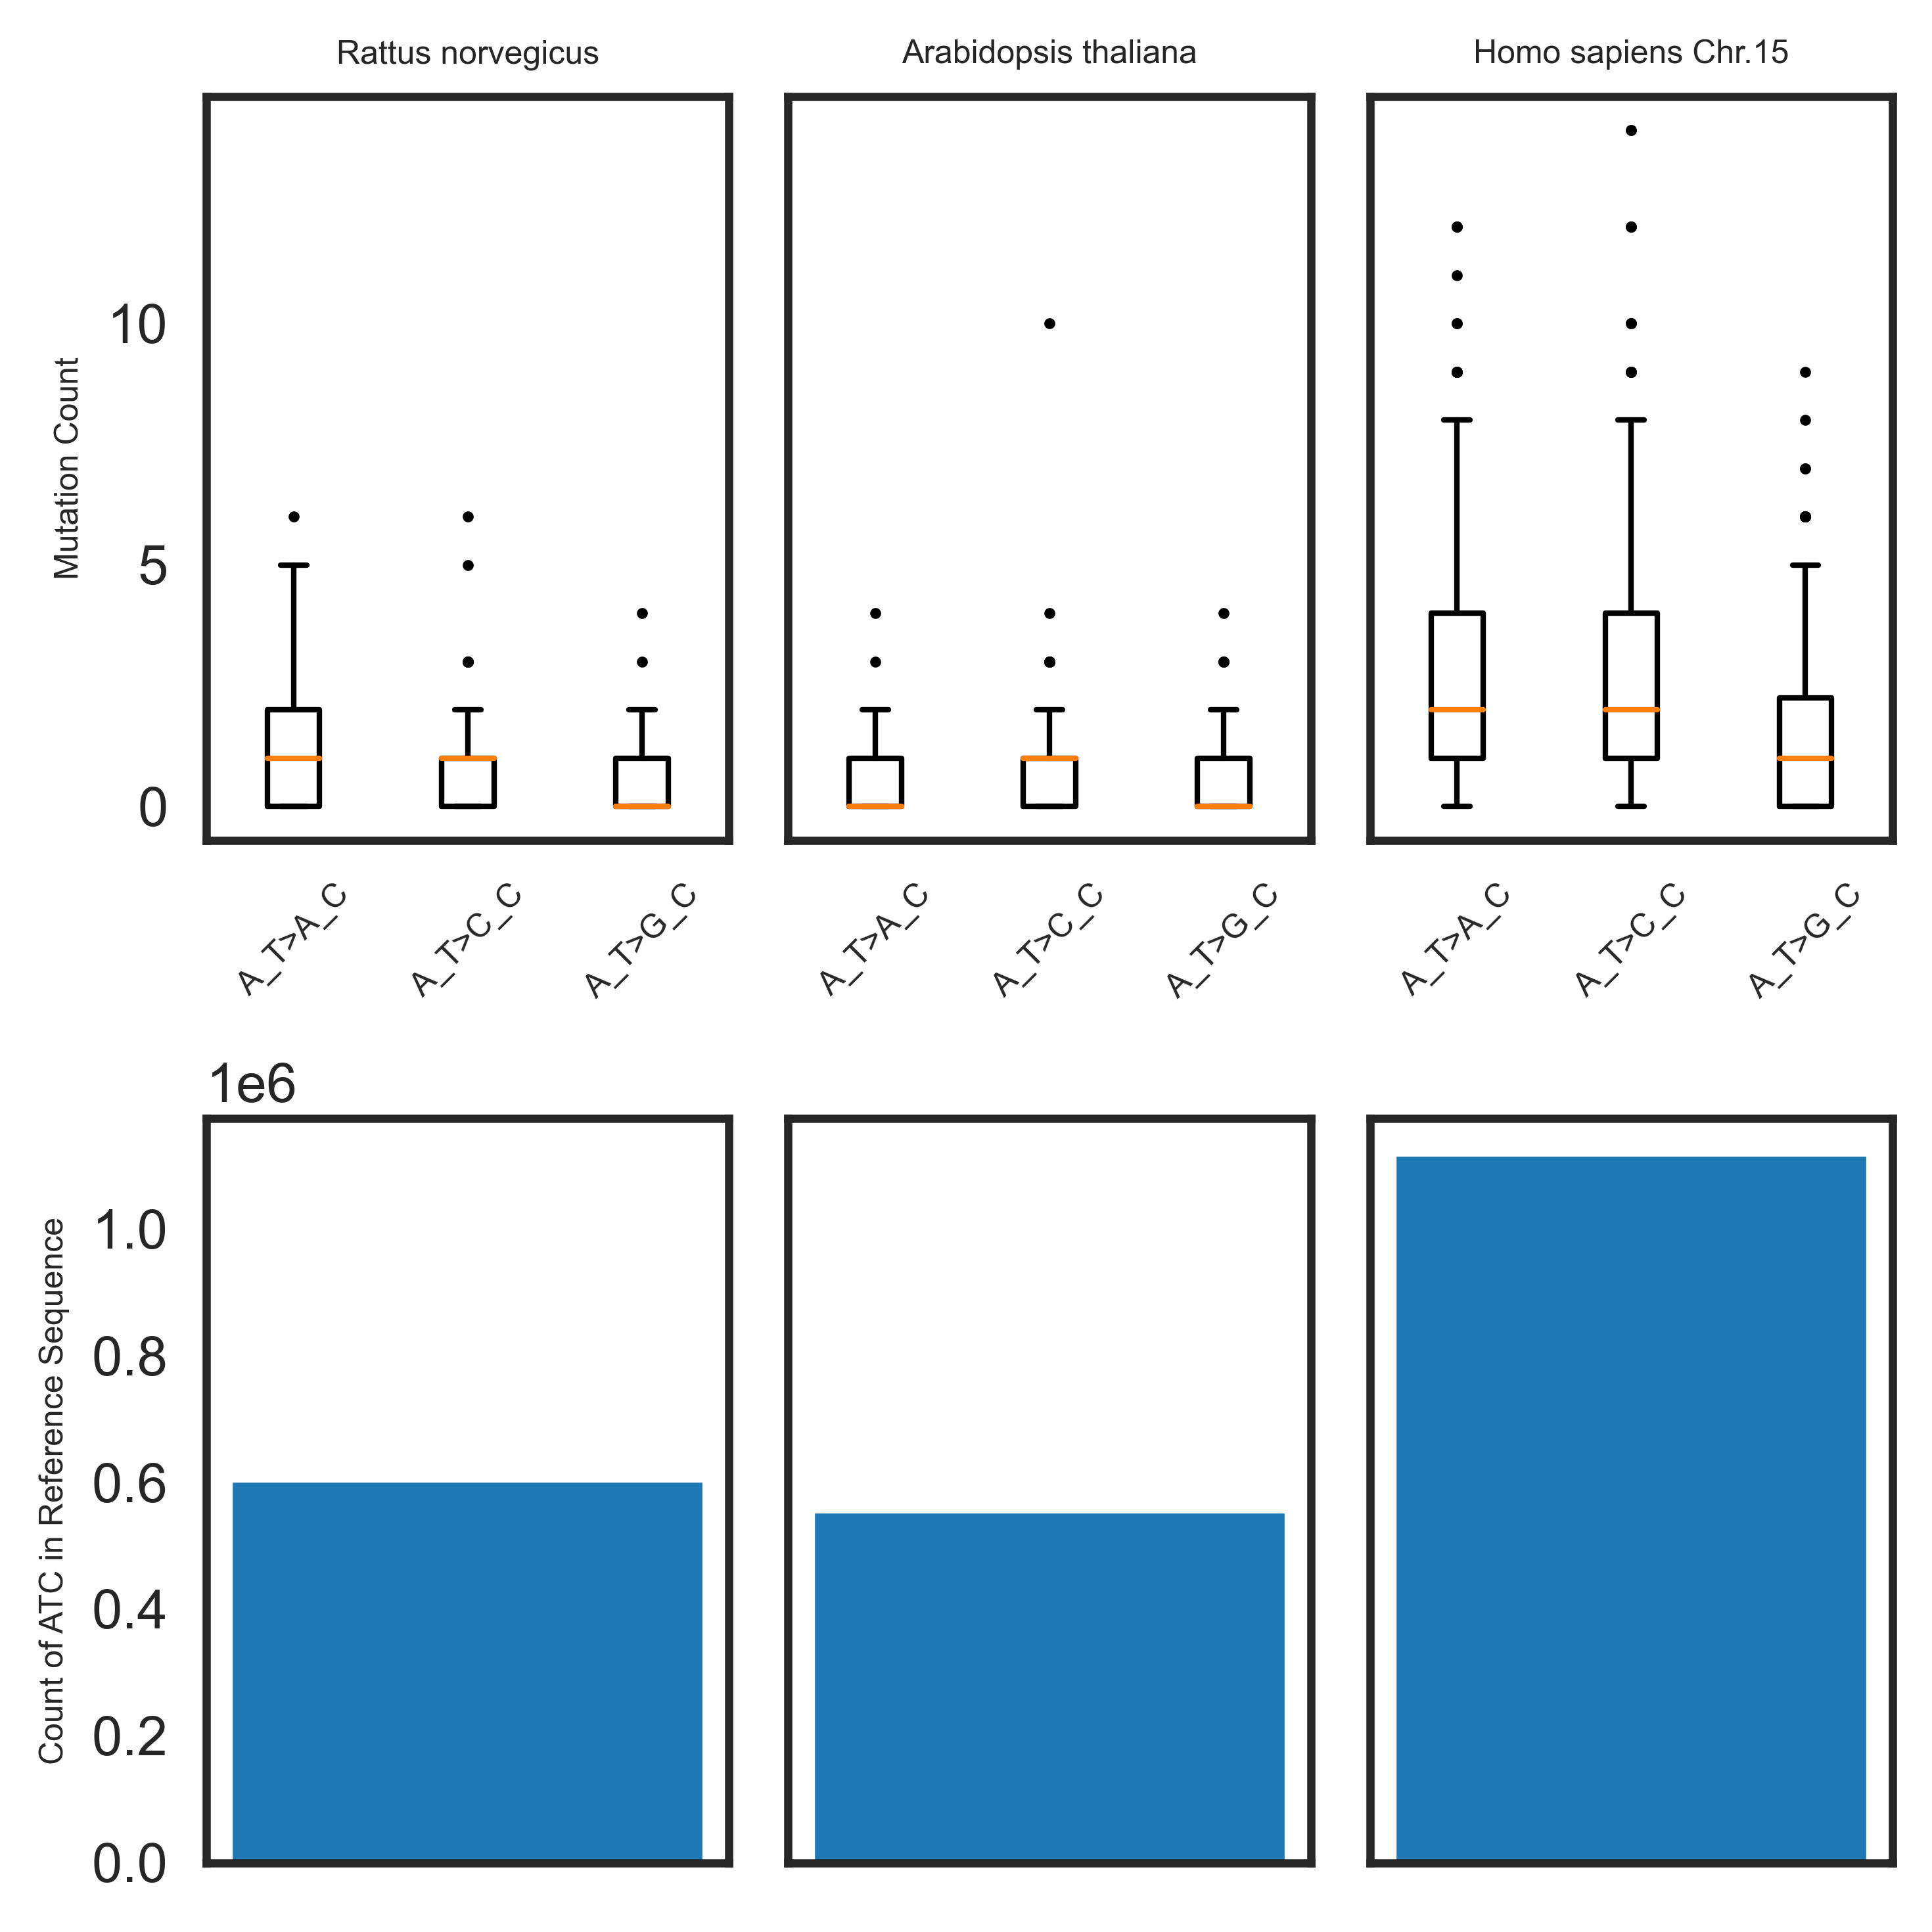

In [159]:
comparison_benchmark(subtype="ATC")

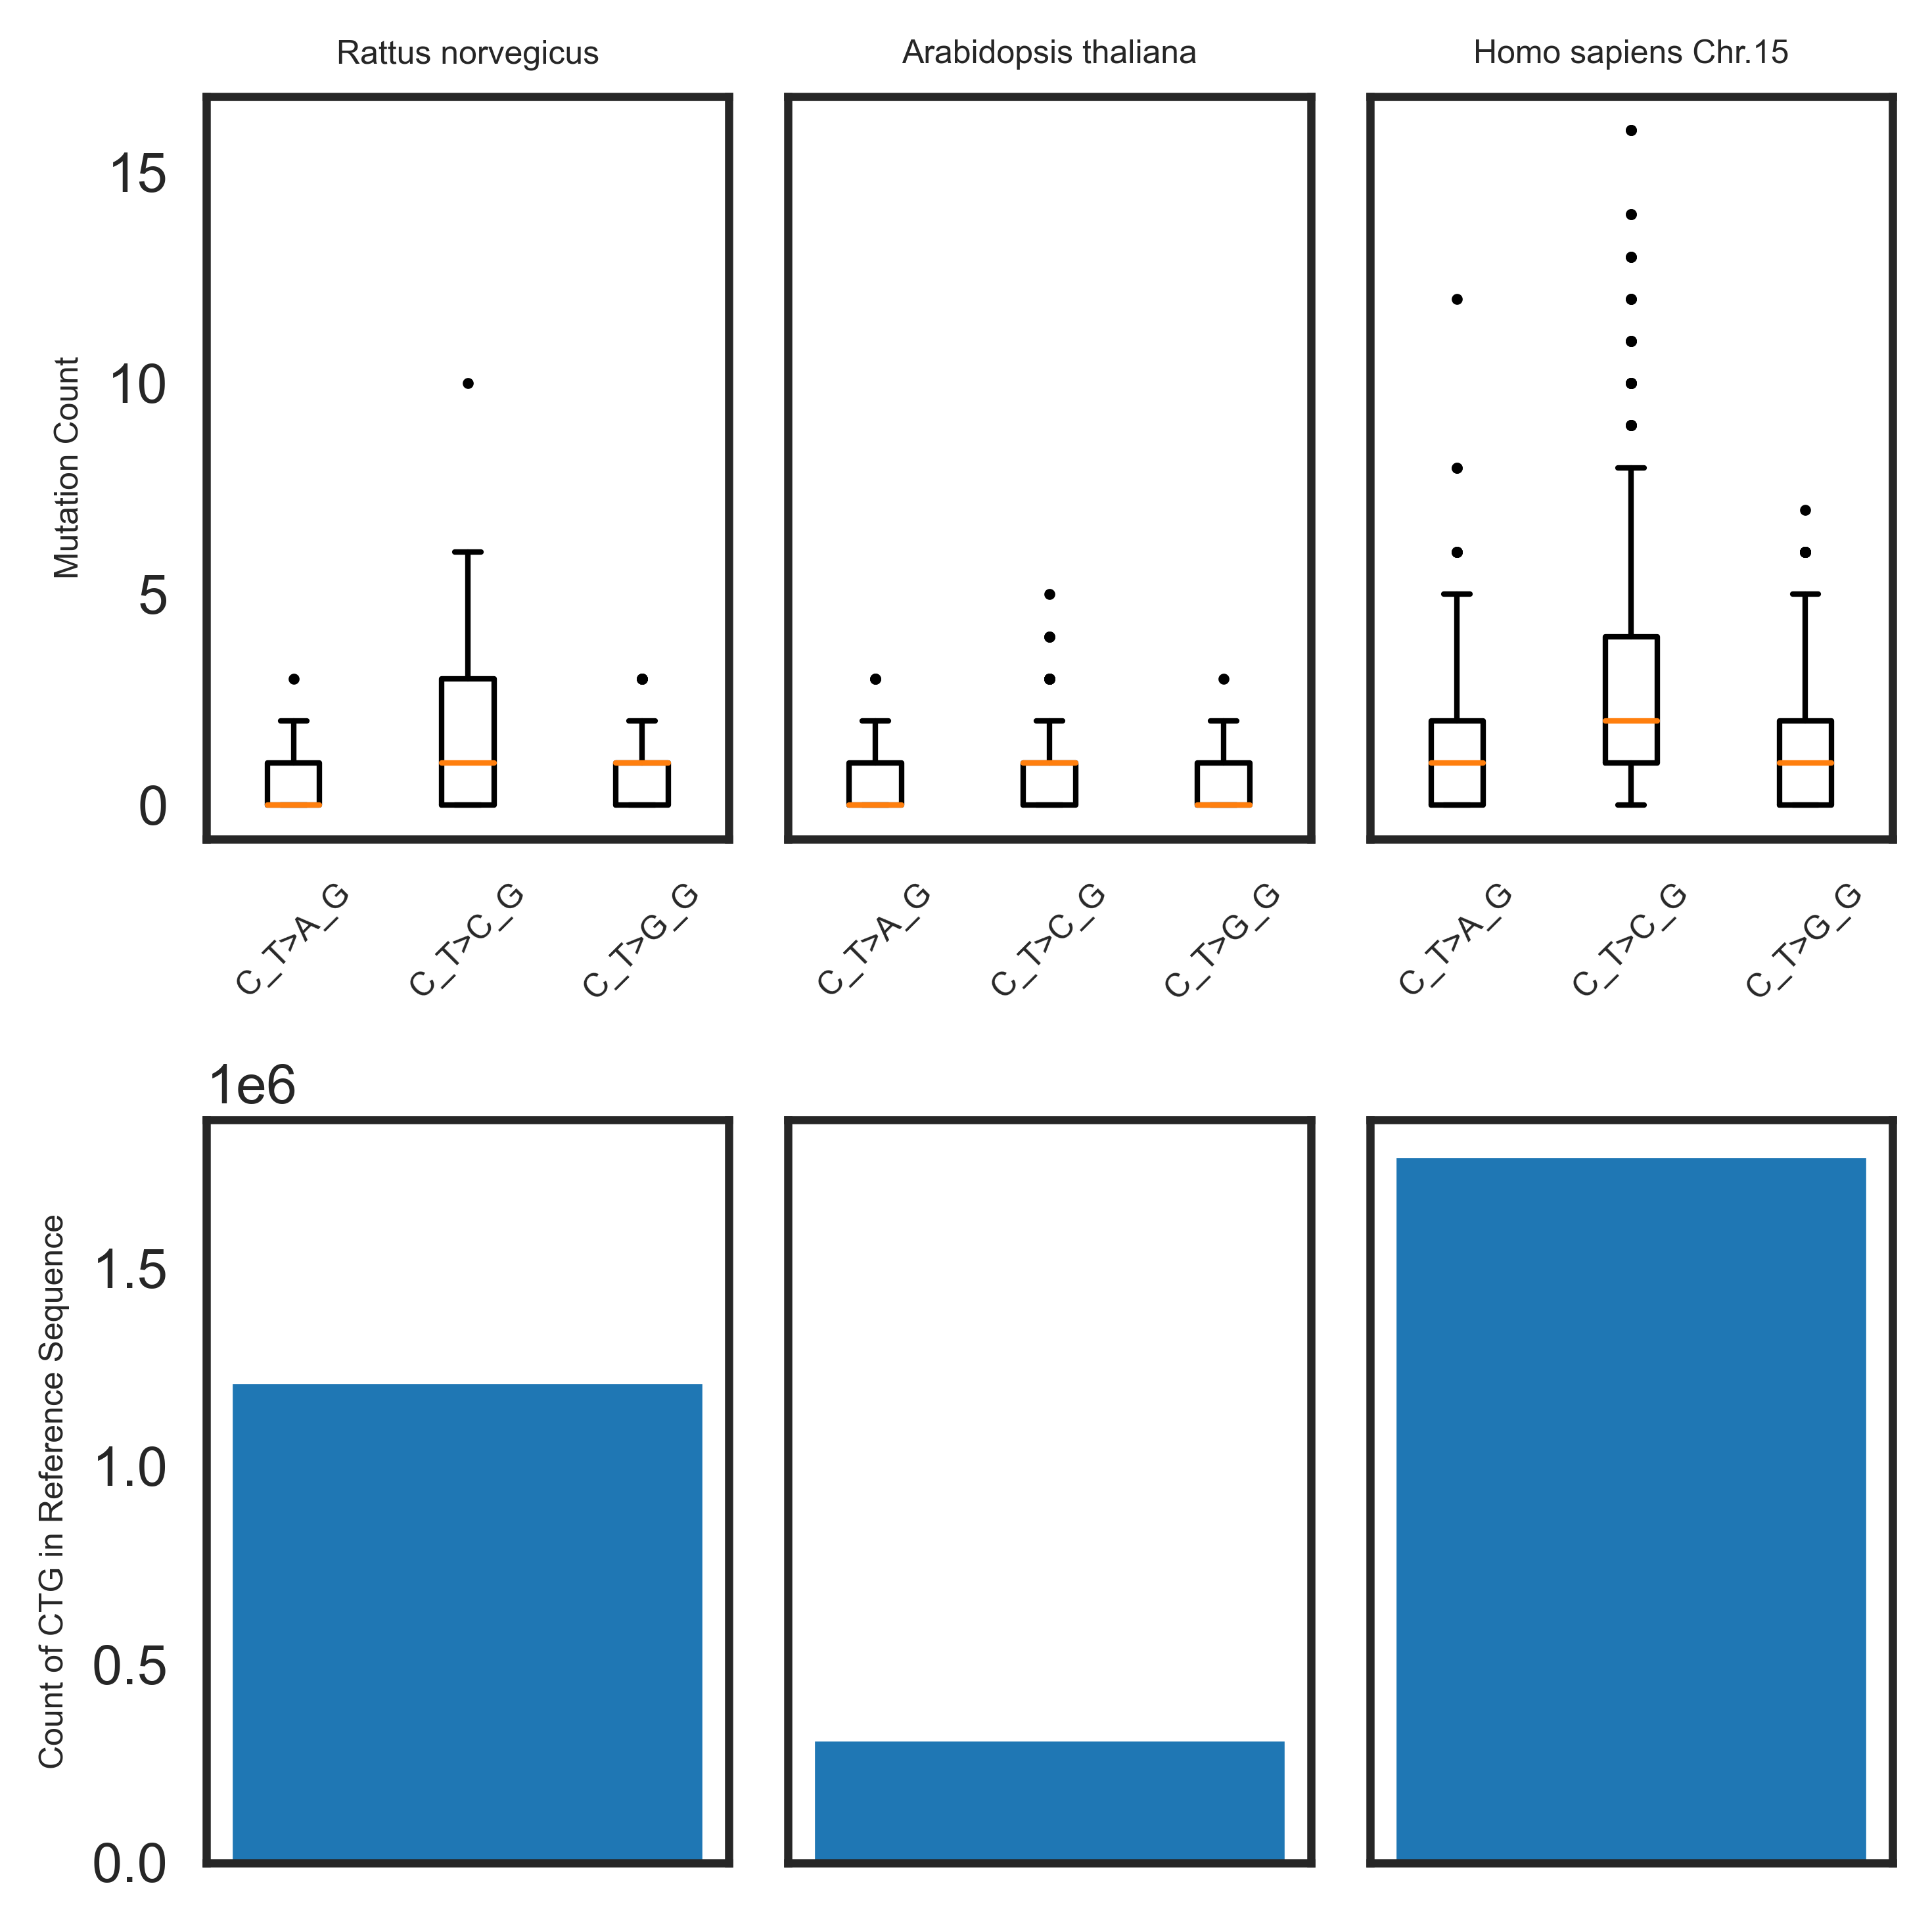

In [160]:
comparison_benchmark(subtype="CTG")